In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold

/users/qdb16186/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# DataBlock

In [2]:
home=os.getcwd()
home

'/users/qdb16186/dev'

# Data CV Block

to adjust CV and hyper parameter setup access:
cv_hp,
adjust test_size and shuffle split
<!--  -->


In [3]:
def path_fold(home,resample,i_fold):
    path="{}/CV/{}/fold_{}".format(os.getcwd(),resample,i_fold)
        
    # Define the directory path
    directory_path = Path(f"{home}/CV/{resample}/{i_fold}")
    
    # Ensure the directory exists, create it if necessary
    directory_path.mkdir(parents=True, exist_ok=True)

    return directory_path

def path_resample(home,resample):
    path="{}/CV/{}/".format(os.getcwd(),resample)
        
    # Define the directory path
    directory_path = Path(f"{home}/CV/{resample}")
    
    # Ensure the directory exists, create it if necessary
    directory_path.mkdir(parents=True, exist_ok=True)

    return directory_path

def cv_hp(df,home):
    resample_split  = ShuffleSplit(50, test_size=0.3, random_state=1)
    fold_split      = ShuffleSplit(5 , test_size=0.3, random_state=1)
    train_val_split = ShuffleSplit(1 , test_size=0.3, random_state=1)
    
    for resample, (train_val_index, test_index) in enumerate(resample_split.split(df)):
        train_val = pd.DataFrame(df['ID'].iloc[train_val_index])
        test = pd.DataFrame(df['ID'].iloc[test_index])
        for i, (train_index, val_index) in enumerate(train_val_split.split(train_val)):
            train = pd.DataFrame(df['ID'].iloc[train_index])
            val   = pd.DataFrame(df['ID'].iloc[val_index])
        resample_path = path_resample(home,resample)
        train.to_csv(f'{resample_path}/train.csv')
        val.to_csv(f'{resample_path}/val.csv')
        test.to_csv(f'{resample_path}/test.csv')
        # train,val,test to_csv
        for i_fold, (train_val_fold_index, test_fold_index) in enumerate(fold_split.split(train)):
            train_val_fold = pd.DataFrame(train['ID'].iloc[train_val_fold_index])
            test_fold = pd.DataFrame(train['ID'].iloc[test_fold_index])
            for i, (train_fold_index, val_fold_index) in enumerate(train_val_split.split(train_val_fold)):
                train_fold = pd.DataFrame(train_val_fold['ID'].iloc[train_fold_index])
                val_fold   = pd.DataFrame(train_val_fold['ID'].iloc[val_fold_index])
            i_fold_path = path_fold(home,resample,i_fold)
            train_fold.to_csv(f'{i_fold_path}/train.csv')
            val_fold.to_csv(f'{i_fold_path}/val.csv')
            test_fold.to_csv(f'{i_fold_path}/test.csv')
            

    return print("data organised into 50 CV with 5-fold inner CV")



In [5]:
df=pd.read_csv("Lomzov_dataset_IY.csv")
home=os.getcwd()
# pathlib.Path("Lomzov_dataset_IY.csv").parent.absolute()
cv_hp(df,home)

data organised into 50 CV with 5-fold inner CV


# Accessing Data Via ID CV and full table

In [4]:
def access_fold_csv(df,home,resample,fold):
    df_path = path_fold(home,resample,fold)
    train_df=pd.read_csv(f'{df_path}/train.csv')
    val_df=pd.read_csv(f'{df_path}/val.csv')
    test_df=pd.read_csv(f'{df_path}/test.csv')

    train_df=df[df["ID"].isin(train_df['ID'])]
    val_df=df[df["ID"].isin(val_df['ID'])]
    test_df=df[df["ID"].isin(test_df['ID'])]
    return train_df, val_df, test_df


def access_resample_csv(df,home,resample):
    df_path = path_resample(home,resample)
    train_df=pd.read_csv(f'{df_path}/train.csv')
    val_df=pd.read_csv(f'{df_path}/val.csv')
    test_df=pd.read_csv(f'{df_path}/test.csv')

    train_df=df[df["ID"].isin(train_df['ID'])]
    val_df=df[df["ID"].isin(val_df['ID'])]
    test_df=df[df["ID"].isin(test_df['ID'])]
    return train_df, val_df, test_df

In [7]:
resample=1
fold=1
train_fold, val_fold, test_fold = access_resample_csv(df,home,resample)

In [8]:
print(train_fold.shape, val_fold.shape, test_fold.shape)
# train_fold.shape
print(train_fold.shape[0] + val_fold.shape[0] + test_fold.shape[0])
# train_fold.shape

(149, 383) (64, 383) (92, 383)
305


# Load X, Y

## Def Functions

In [5]:
def padding(X_descr_train_scaled):
#     Padding function so X data is always 250 dimensions
# Must be coupled with load_data. NB! double check if the scalling is not affected
# https://www.geeksforgeeks.org/python-call-function-from-another-function/
    a=X_descr_train_scaled.to_numpy()
    b=np.zeros((len(X_descr_train_scaled), 
                (250-int(X_descr_train_scaled.to_numpy().shape[1]))
               )
              )
    padded=np.concatenate((a,b),
                           axis=1, 
                          out=None, 
                          dtype=None
                         )
    return padded


def load_xy(file,desc):
    # Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()

    Y = file[['dH','dS','dG','Tm']].copy()
    # Convert y data into required input shape
    y_1 = y_1.to_numpy()
    y_1 = y_1.reshape(y_1.shape[0])
    y_2 = y_2.to_numpy()
    y_2 = y_2.reshape(y_2.shape[0])
    y_3 = y_3.to_numpy()
    y_3 = y_3.reshape(y_3.shape[0])
    y_4 = y_4.to_numpy()
    y_4 = y_4.reshape(y_4.shape[0])
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{desc}_'in col]]
    
    return y_1, y_2, y_3, y_4, Y, padding(X), X

    

    

## Variables

In [10]:
df=pd.read_csv("Lomzov_dataset_IY.csv")
home=os.getcwd()
# pathlib.Path("Lomzov_dataset_IY.csv").parent.absolute()
cv_hp(df,home)

resample=1
fold=1
train, val, test = access_resample_csv(df,home,resample)
train_fold, val_fold, test_fold = access_fold_csv(df,home,resample,fold)

desc='Granulated'
y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train_fold,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val_fold,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test_fold,desc)


data organised into 50 CV with 5-fold inner CV


# Model

In [6]:
# !pip install keras_tuner

In [7]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

2024-06-13 20:29:32.903163: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 20:29:35.668686: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 20:29:35.669624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 20:29:53.326590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
def r2_func(y_true, y_pred, **kwargs):
    return metrics.r2_score(y_true, y_pred)
def rmse_func(y_true, y_pred, **kwargs):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))  
def bias_func(y_true, y_pred, **kwargs):
    return np.mean(y_true-y_pred)
def sdep_func(y_true, y_pred, **kwargs):
    return (np.mean((y_true-y_pred-(np.mean(y_true-y_pred)))**2))**0.5
#these 4 are for tensorflow formats
def r2_func_tf(y_true, y_pred, **kwargs):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - numerator / denominator
    return r2
def rmse_func_tf(y_true, y_pred, **kwargs):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse
def bias_func_tf(y_true, y_pred, **kwargs):
    bias = tf.reduce_mean(y_true - y_pred)
    return bias
def sdep_func_tf(y_true, y_pred, **kwargs):
    diff = y_true - y_pred
    mean_diff = tf.reduce_mean(diff)
    sdep = tf.sqrt(tf.reduce_mean(tf.square(diff - mean_diff)))
    return sdep

## Model without hyper parameters

### 3CCN #3NN

In [34]:

def build_model(hp=0):
     
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x_layer=inputs
    
    # Conv layer 1
    x_layer = keras.layers.Conv1D(32, 
            kernel_size=(3), 
            strides=(2), 
            padding='valid', 
            activation='relu', 
            input_shape=(250,1),
            name = 'conv1d_1'
            )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = 'batchnorm_1')(x_layer)



    # Conv layer 2
    x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        name = f'conv1d_2'
                        )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = f'batchnorm_2')(x_layer)


    # Conv layer 3
    x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        name = f'conv1d_3'
                        )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = f'batchnorm_3')(x_layer)
                
#     FLATTEN AFTER CONVOLUTIONS
    x_layer = keras.layers.Flatten(name = 'flatten')(x_layer)
    
    
    #Node 1
    node1_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node1_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node1_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node1_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node1_layer)


    node1_layer = keras.layers.Dense(
                16,
                activation='relu',
                name='node1_3',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node1_layer)
    
    
    #Node 2
    node2_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node2_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node2_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node2_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node2_layer)


    node2_layer = keras.layers.Dense(
                16,
                activation='relu',
                name='node2_3',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node2_layer)
    
    #Node 3
    node3_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node3_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node3_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node3_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node3_layer)


    node3_layer = keras.layers.Dense(
                16,
                activation='relu',
                name='node3_3',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node3_layer)
    
    #Node 4
    node4_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node4_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node4_layer = keras.layers.Dense(
                32,
                activation='relu',
                use_bias=True,
                name='node4_2',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node4_layer)


    node4_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node4_3',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node4_layer)
#     OUTPUT LAYERS

    # output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x_layer)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x_layer)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x_layer)
    # output_4 = keras.layers.Dense(1, name='melting_temperature')(x_layer)

    output_1 = keras.layers.Dense(1, name='dH')(node1_layer)
    output_2 = keras.layers.Dense(1, name='dS')(node2_layer)
    output_3 = keras.layers.Dense(1, name='dG')(node3_layer)
    output_4 = keras.layers.Dense(1, name='Tm')(node4_layer)
    

    model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4])
    # output_1 = keras.layers.Dense(1, name='output')(x_layer)
    # model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS

# #     ADAPTIVE LEARNING RATE   
    
#     initial_learning_rate = 0.01
#     decay_steps = 10.0
#     decay_rate = 0.5
#     learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
#                                     initial_learning_rate, decay_steps, decay_rate)
    
# #     SETTING ADAM OPTIMISER
#     optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
# #     COMPILE MODEl
#     model.compile(loss = "mse" , 
#                   optimizer = optimiser, 
#                   metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

### 2CNN 2NN

In [132]:

def build_model(hp=0):
     
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x_layer=inputs
    
    # Conv layer 1
    x_layer = keras.layers.Conv1D(32, 
            kernel_size=(3), 
            strides=(2), 
            padding='valid', 
            activation='relu', 
            input_shape=(250,1),
            name = 'conv1d_1'
            )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = 'batchnorm_1')(x_layer)



    # Conv layer 2
    x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        name = f'conv1d_2'
                        )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = f'batchnorm_2')(x_layer)


#     FLATTEN AFTER CONVOLUTIONS
    x_layer = keras.layers.Flatten(name = 'flatten')(x_layer)
    
    
    #Node 1
    node1_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node1_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node1_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node1_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node1_layer)
    
    #Node 2
    node2_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node2_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node2_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node2_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node2_layer)
    
    #Node 3
    node3_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node3_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node3_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node3_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node3_layer)
    
    #Node 4
    node4_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node4_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node4_layer = keras.layers.Dense(
                32,
                activation='relu',
                use_bias=True,
                name='node4_2',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node4_layer)



#     OUTPUT LAYERS

    # output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x_layer)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x_layer)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x_layer)
    # output_4 = keras.layers.Dense(1, name='melting_temperature')(x_layer)

    output_1 = keras.layers.Dense(1, name='dH')(node1_layer)
    output_2 = keras.layers.Dense(1, name='dS')(node2_layer)
    output_3 = keras.layers.Dense(1, name='dG')(node3_layer)
    output_4 = keras.layers.Dense(1, name='Tm')(node4_layer)
    

    model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4])

#     SETTINGS

# #     ADAPTIVE LEARNING RATE   
    
#     initial_learning_rate = 0.01
#     decay_steps = 10.0
#     decay_rate = 0.5
#     learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
#                                     initial_learning_rate, decay_steps, decay_rate)
    
# #     SETTING ADAM OPTIMISER
#     optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
# #     COMPILE MODEl
#     model.compile(loss = "mse" , 
#                   optimizer = optimiser, 
#                   metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

### NN

In [23]:

def build_model(hp=0):
     
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x_layer=inputs

    x_layer = keras.layers.Flatten(name = 'flatten')(x_layer)
    #Node 1
    node1_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node1_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node1_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node1_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node1_layer)
    
    #Node 2
    node2_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node2_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node2_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node2_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node2_layer)
    
    #Node 3
    node3_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node3_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node3_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node3_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node3_layer)
    
    #Node 4
    node4_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node4_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node4_layer = keras.layers.Dense(
                32,
                activation='relu',
                use_bias=True,
                name='node4_2',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node4_layer)



#     OUTPUT LAYERS

    # output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x_layer)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x_layer)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x_layer)
    # output_4 = keras.layers.Dense(1, name='melting_temperature')(x_layer)

    output_1 = keras.layers.Dense(1, name='dH')(node1_layer)
    output_2 = keras.layers.Dense(1, name='dS')(node2_layer)
    output_3 = keras.layers.Dense(1, name='dG')(node3_layer)
    output_4 = keras.layers.Dense(1, name='Tm')(node4_layer)
    

    model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4])

#     SETTINGS

# #     ADAPTIVE LEARNING RATE   
    
#     initial_learning_rate = 0.01
#     decay_steps = 10.0
#     decay_rate = 0.5
#     learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
#                                     initial_learning_rate, decay_steps, decay_rate)
    
# #     SETTING ADAM OPTIMISER
#     optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
# #     COMPILE MODEl
#     model.compile(loss = "mse" , 
#                   optimizer = optimiser, 
#                   metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

## Initiaalise the model

In [14]:
epochs = 2
batch  = 16
# TODO: Use path lib to create path
fold_path = path_fold(home,resample,fold)
resample_path = path_resample(home,resample)

# model_name = architecture of - Single task/RF/KNN + dH/dG/dS/Tm or - Multitask  
prop = 'HGST' 
model_name = f"1DConv_mt_{prop}" 


# Define the directory path
directory_path = Path(f"{fold_path}/{desc}/{model_name}/")

tunner_path      = Path(f'{directory_path}/tunner')
csv_logger_path  = Path(f'{directory_path}/csv_logger/')
cp_callback_path = Path(f'{directory_path}/model_checkpoint/')
tensorboard_path = Path(f'{directory_path}/tensorboard_logs/')

# Ensure the directory exists, create it if necessary
tunner_path.mkdir(parents=True, exist_ok=True)
csv_logger_path.mkdir(parents=True, exist_ok=True)
cp_callback_path.mkdir(parents=True, exist_ok=True)
tensorboard_path.mkdir(parents=True, exist_ok=True)


tuner = kt.GridSearch(build_model,
                   objective=kt.Objective('val_loss', 'min'),
                    # loss = 'val_loss',
                   # objective = ['val_mse','val_free_energy_pred_mse'],
                  directory=tunner_path,
                  overwrite=False,
                  project_name=f'{batch}')

with open(f'{tunner_path}/tuner_path.txt', 'w') as f:
    f.write(tuner.project_dir)
f.close

#### CALL BACKS!
es = EarlyStopping(monitor      = 'val_loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 2000, 
                    restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history.csv' , append=True)

# CP_callbacks      not required when using a tunner       
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp.ckpt',
#                                                  save_weights_only=True,
#                                                  verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, tensorboard_callback]


# history=tuner.search(x_hp_train, y_hp_train[:],
#             epochs = epochs,
#             batch_size=batch,
#             verbose = 2,
#             validation_data =(x_hp_val, y_hp_val[:]),
#              # validation_split = 0.2,
#             callbacks=keras_callbacks)

Reloading Tuner from /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/tunner/16/tuner0.json


## Tuning

In [15]:
y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train_fold,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val_fold,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test_fold,desc)

In [16]:
# X_test

In [23]:
model = build_model()
# history = model.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
#                     epochs=2,
#                     batch_size=16, 
#                     validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
#                     verbose = 3,
#                     callbacks=keras_callbacks)

In [25]:
model.


In [19]:
# history.model.get_weights()

In [20]:
history.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 1)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 124, 32)      128         ['input_1[0][0]']                
                                                                                                  
 maxpooling_1 (MaxPooling1D)    (None, 62, 32)       0           ['conv1d_1[0][0]']               
                                                                                                  
 batchnorm_1 (BatchNormalizatio  (None, 62, 32)      128         ['maxpooling_1[0][0]']           
 n)                                                                                           

In [21]:
history.model.predict

<bound method Model.predict of <keras.engine.functional.Functional object at 0x14ab000d8cd0>>

In [9]:
# from sklearn import metrics
# from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.metrics import mean_absolute_error
import sys

In [10]:
def stats_hp(y_test_pred, Y_test, prop):
    y_test_np = Y_test[f'{prop}'].to_numpy()
    y_pred_test_np = y_test_pred

    r2_test = r2_score(y_test_np, y_pred_test_np)
    rmsd_test = (mean_squared_error(y_test_np, y_pred_test_np))**0.5
    bias_test = np.mean(y_pred_test_np - y_test_np)
    sdep_test = (np.mean((y_pred_test_np - y_test_np - bias_test)**2))**0.5
    r2 = '{:.3f}'.format(r2_test)
    rmsd = '{:.3f}'.format(rmsd_test)
    bias = '{:.3f}'.format(bias_test)
    sdep = '{:.3f}'.format(sdep_test)
    
    
    mse=mean_squared_error(y_test_np, y_pred_test_np)
    mse='{:.3f}'.format(mse)
    mae=mean_absolute_error(y_test_np, y_pred_test_np)
    mae='{:.3f}'.format(mae)
    try:
        a, b = np.polyfit(y_test_np, y_pred_test_np, 1)
        plot_a = '{:.3f}'.format(a[0])
        plot_b = '{:.3f}'.format(b[0])
    except np.linalg.LinAlgError:
        pass
    
    return r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae

In [ ]:
y_test_pred = model.predict(X_padded_test)
# y_test_pred
r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[3], Y_test, 'Tm')
r2

In [ ]:
model2 = build_model()


In [26]:
for layer in model2.layers:
    layer.trainable=True
    if layer.name in ['node1_1','node1_2','node1_3']:
        layer.trainable=False
        print(layer.name, layer)

node1_1 <keras.layers.core.dense.Dense object at 0x14a8231a4340>
node1_2 <keras.layers.core.dense.Dense object at 0x14a8231ab790>
node1_3 <keras.layers.core.dense.Dense object at 0x14a8231abbb0>


In [49]:
cp_callback_path

PosixPath('/users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint')

In [58]:
from keras.models import load_model

In [60]:

#### CALL BACKS!
es = EarlyStopping(monitor      = 'loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 100,)
                    # restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history.csv' , append=True)

# CP_callbacks      not required when using a tunner       
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp.h5',#ckpt',
                                                 monitor = 'val_loss',
                                                save_best_only = True,
                                                 save_weights_only=True,
                                                 verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, cp_callback, tensorboard_callback]







# Initialise model for one single resample/hyper param tuning (train cycle)
model2 = build_model()





# Fit convolutional layers on all properties and optimisied initial fingures.
history = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                        epochs=600,
                        batch_size=16, 
                        validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                        verbose = 3,
                        callbacks=keras_callbacks)
# fine tune each finger, keep convolutional layers frozen



Epoch 1/600

Epoch 1: val_loss improved from inf to 9049.55664, saving model to /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint/cp.h5
Epoch 2/600

Epoch 2: val_loss did not improve from 9049.55664
Epoch 3/600

Epoch 3: val_loss did not improve from 9049.55664
Epoch 4/600

Epoch 4: val_loss did not improve from 9049.55664
Epoch 5/600

Epoch 5: val_loss did not improve from 9049.55664
Epoch 6/600

Epoch 6: val_loss did not improve from 9049.55664
Epoch 7/600

Epoch 7: val_loss did not improve from 9049.55664
Epoch 8/600

Epoch 8: val_loss did not improve from 9049.55664
Epoch 9/600

Epoch 9: val_loss did not improve from 9049.55664
Epoch 10/600

Epoch 10: val_loss did not improve from 9049.55664
Epoch 11/600

Epoch 11: val_loss did not improve from 9049.55664
Epoch 12/600

Epoch 12: val_loss did not improve from 9049.55664
Epoch 13/600

Epoch 13: val_loss did not improve from 9049.55664
Epoch 14/600

Epoch 14: val_loss did not improve from 9049.55664
Epoch 15/600

E

In [61]:
for finger in range(1,5):
    model2 = build_model()
    model2.load_weights(f'{cp_callback_path}/cp.h5')
    # finger = 4
    for layer in model2.layers:
        layer.trainable=False
        if layer.name in [f'node{finger}_1',f'node{finger}_2',f'node{finger}_3',prop[finger-1]]:
            layer.trainable=True
            print(layer.name, layer)
    
    
    history = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                        epochs=600,
                        batch_size=16, 
                        validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                        verbose = 3,
                        callbacks=keras_callbacks)


model2 = build_model()
model2.load_weights(f'{cp_callback_path}/cp.h5')

node1_1 <keras.layers.core.dense.Dense object at 0x14a822303c70>
node1_2 <keras.layers.core.dense.Dense object at 0x14a822303490>
node1_3 <keras.layers.core.dense.Dense object at 0x14a822303700>
dH <keras.layers.core.dense.Dense object at 0x14a822303940>
Epoch 1/600

Epoch 1: val_loss did not improve from 288.60550
Epoch 2/600

Epoch 2: val_loss did not improve from 288.60550
Epoch 3/600

Epoch 3: val_loss did not improve from 288.60550
Epoch 4/600

Epoch 4: val_loss did not improve from 288.60550
Epoch 5/600

Epoch 5: val_loss did not improve from 288.60550
Epoch 6/600

Epoch 6: val_loss did not improve from 288.60550
Epoch 7/600

Epoch 7: val_loss did not improve from 288.60550
Epoch 8/600

Epoch 8: val_loss did not improve from 288.60550
Epoch 9/600

Epoch 9: val_loss did not improve from 288.60550
Epoch 10/600

Epoch 10: val_loss did not improve from 288.60550
Epoch 11/600

Epoch 11: val_loss did not improve from 288.60550
Epoch 12/600

Epoch 12: val_loss did not improve from 288.6

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x14ab9f68ed30>.

In [62]:
model2 = build_model()
model2.load_weights(f'{cp_callback_path}/cp.h5')

In [64]:
#### CALL BACKS!
es = EarlyStopping(monitor      = 'val_loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 1000,
                    restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history1.csv' , append=True)

# CP_callbacks      not required when using a tunner       
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp1.h5',#ckpt',
                                                 monitor = 'val_loss',
                                                save_best_only = True,
                                                 save_weights_only=True,
                                                 verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, cp_callback, tensorboard_callback]







# Initialise model for one single resample/hyper param tuning (train cycle)
model2 = build_model()





# Fit convolutional layers on all properties and optimisied initial fingures.
history = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                        epochs=600,
                        batch_size=16, 
                        validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                        verbose = 3,
                        callbacks=keras_callbacks)

Epoch 1/600

Epoch 1: val_loss improved from inf to 29197.44531, saving model to /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint/cp1.h5
Epoch 2/600

Epoch 2: val_loss did not improve from 29197.44531
Epoch 3/600

Epoch 3: val_loss did not improve from 29197.44531
Epoch 4/600

Epoch 4: val_loss did not improve from 29197.44531
Epoch 5/600

Epoch 5: val_loss improved from 29197.44531 to 22776.90234, saving model to /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint/cp1.h5
Epoch 6/600

Epoch 6: val_loss did not improve from 22776.90234
Epoch 7/600

Epoch 7: val_loss did not improve from 22776.90234
Epoch 8/600

Epoch 8: val_loss did not improve from 22776.90234
Epoch 9/600

Epoch 9: val_loss did not improve from 22776.90234
Epoch 10/600

Epoch 10: val_loss did not improve from 22776.90234
Epoch 11/600

Epoch 11: val_loss did not improve from 22776.90234
Epoch 12/600

Epoch 12: val_loss did not improve from 22776.90234
Epoch 13/600

Epoch 13: val_lo

In [28]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
    

2/2 [==============================] - 0s 4ms/step
dH: r2=0.932, rmsd=6.431, mse=41.354, mae=5.031
dS: r2=0.919, rmsd=18.766, mse=352.147, mae=14.747
dG: r2=0.962, rmsd=0.860, mse=0.739, mae=0.638
Tm: r2=0.905, rmsd=4.178, mse=17.455, mae=3.105


In [85]:
finger = 2
for layer in model2.layers:
    layer.trainable=False
    print(layer.name)
    if layer.name in [f'node{finger}_1',f'node{finger}_2',f'node{finger}_3']:#,prop[finger-1]]:#
        layer.trainable=True
        print(layer.name, layer)
    print("weights:", len(layer.weights))
    print("trainable_weights:", len(layer.trainable_weights))
    print("non_trainable_weights:", len(layer.non_trainable_weights))
    # print(layer.trainable_weights)
history = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                        epochs=600,
                        batch_size=16, 
                        validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                        verbose = 3,
                        callbacks=keras_callbacks)

input_12
weights: 0
trainable_weights: 0
non_trainable_weights: 0
conv1d_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_1
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_1
weights: 4
trainable_weights: 0
non_trainable_weights: 4
conv1d_2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_2
weights: 4
trainable_weights: 0
non_trainable_weights: 4
conv1d_3
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_3
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_3
weights: 4
trainable_weights: 0
non_trainable_weights: 4
flatten
weights: 0
trainable_weights: 0
non_trainable_weights: 0
node1_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node2_1
node2_1 <keras.layers.core.dense.Dense object at 0x14ac555e7880>
weights: 2
trainable_weights: 2
non_trainable_weights: 0
node3_1
weights: 2
trainable_weights: 0
non_trainable_weigh

In [86]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
    

2/2 [==============================] - 0s 3ms/step
dH: r2=0.896, rmsd=7.945, mse=63.126, mae=6.136
dS: r2=0.880, rmsd=22.845, mse=521.878, mae=17.711
dG: r2=0.919, rmsd=1.254, mse=1.572, mae=0.900
Tm: r2=0.885, rmsd=4.581, mse=20.987, mae=3.574


In [83]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.892, rmsd=8.105, mse=65.696, mae=6.262
dS: r2=0.876, rmsd=23.230, mse=539.622, mae=18.022
dG: r2=0.917, rmsd=1.267, mse=1.605, mae=0.908
Tm: r2=0.885, rmsd=4.591, mse=21.078, mae=3.583


In [81]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.913, rmsd=7.267, mse=52.805, mae=5.735
dS: r2=0.897, rmsd=21.193, mse=449.156, mae=16.610
dG: r2=0.932, rmsd=1.148, mse=1.317, mae=0.835
Tm: r2=0.886, rmsd=4.562, mse=20.809, mae=3.537


In [79]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.896, rmsd=7.957, mse=63.318, mae=6.154
dS: r2=0.882, rmsd=22.678, mse=514.312, mae=17.694
dG: r2=0.912, rmsd=1.306, mse=1.705, mae=0.938
Tm: r2=0.866, rmsd=4.958, mse=24.587, mae=3.925


In [65]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.896, rmsd=7.965, mse=63.448, mae=6.141
dS: r2=0.886, rmsd=22.263, mse=495.643, mae=17.274
dG: r2=0.897, rmsd=1.411, mse=1.990, mae=1.056
Tm: r2=0.827, rmsd=5.621, mse=31.601, mae=4.411


In [54]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.848, rmsd=9.631, mse=92.766, mae=7.426
dS: r2=0.824, rmsd=27.700, mse=767.280, mae=21.583
dG: r2=0.742, rmsd=2.232, mse=4.980, mae=1.756
Tm: r2=0.659, rmsd=7.895, mse=62.334, mae=6.340


In [63]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.930, rmsd=6.547, mse=42.870, mae=5.099
dS: r2=0.917, rmsd=18.979, mse=360.203, mae=15.003
dG: r2=0.936, rmsd=1.112, mse=1.236, mae=0.893
Tm: r2=0.818, rmsd=5.768, mse=33.265, mae=4.127


In [29]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 1)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 124, 32)      128         ['input_2[0][0]']                
                                                                                                  
 maxpooling_1 (MaxPooling1D)    (None, 62, 32)       0           ['conv1d_1[0][0]']               
                                                                                                  
 batchnorm_1 (BatchNormalizatio  (None, 62, 32)      128         ['maxpooling_1[0][0]']           
 n)                                                                                         

In [48]:
finger = 4
for layer in model2.layers:
    layer.trainable=False
    if layer.name in [f'node{finger}_1',f'node{finger}_2',f'node{finger}_3',prop[finger-1]]:
        layer.trainable=True
        print(layer.name, layer)

node4_1 <keras.layers.core.dense.Dense object at 0x14a8b0fda400>
node4_2 <keras.layers.core.dense.Dense object at 0x14a8b0fc1e50>
node4_3 <keras.layers.core.dense.Dense object at 0x14a8b0fc1e80>
Tm <keras.layers.core.dense.Dense object at 0x14a8b0ff1220>


In [31]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 1)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 124, 32)      128         ['input_2[0][0]']                
                                                                                                  
 maxpooling_1 (MaxPooling1D)    (None, 62, 32)       0           ['conv1d_1[0][0]']               
                                                                                                  
 batchnorm_1 (BatchNormalizatio  (None, 62, 32)      128         ['maxpooling_1[0][0]']           
 n)                                                                                         

In [32]:
history2 = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                    epochs=600,
                    batch_size=16, 
                    validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                    verbose = 3,
                    callbacks=keras_callbacks)

Epoch 1/600
Epoch 2/600
Epoch 3/600
Epoch 4/600
Epoch 5/600
Epoch 6/600
Epoch 7/600
Epoch 8/600
Epoch 9/600
Epoch 10/600
Epoch 11/600
Epoch 12/600
Epoch 13/600
Epoch 14/600
Epoch 15/600
Epoch 16/600
Epoch 17/600
Epoch 18/600
Epoch 19/600
Epoch 20/600
Epoch 21/600
Epoch 22/600
Epoch 23/600
Epoch 24/600
Epoch 25/600
Epoch 26/600
Epoch 27/600
Epoch 28/600
Epoch 29/600
Epoch 30/600
Epoch 31/600
Epoch 32/600
Epoch 33/600
Epoch 34/600
Epoch 35/600
Epoch 36/600
Epoch 37/600
Epoch 38/600
Epoch 39/600
Epoch 40/600
Epoch 41/600
Epoch 42/600
Epoch 43/600
Epoch 44/600
Epoch 45/600
Epoch 46/600
Epoch 47/600
Epoch 48/600
Epoch 49/600
Epoch 50/600
Epoch 51/600
Epoch 52/600
Epoch 53/600
Epoch 54/600
Epoch 55/600
Epoch 56/600
Epoch 57/600
Epoch 58/600
Epoch 59/600
Epoch 60/600
Epoch 61/600
Epoch 62/600
Epoch 63/600
Epoch 64/600
Epoch 65/600
Epoch 66/600
Epoch 67/600
Epoch 68/600
Epoch 69/600
Epoch 70/600
Epoch 71/600
Epoch 72/600
Epoch 73/600
Epoch 74/600
Epoch 75/600
Epoch 76/600
Epoch 77/600
Epoch 78

In [33]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
for n in range(4):
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.934, rmsd=6.322, mse=39.964, mae=5.054
dS: r2=0.919, rmsd=18.750, mse=351.553, mae=14.970
dG: r2=0.970, rmsd=0.756, mse=0.571, mae=0.568
Tm: r2=0.924, rmsd=3.725, mse=13.879, mae=2.731


# Model Eval 2CNN 2NN

In [66]:
#### CALL BACKS!
es = EarlyStopping(monitor      = 'val_loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 1000,
                    restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history1.csv' , append=True)

# CP_callbacks      not required when using a tunner       
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp1.h5',#ckpt',
                                                 monitor = 'val_loss',
                                                save_best_only = True,
                                                 save_weights_only=True,
                                                 verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, cp_callback, tensorboard_callback]







# Initialise model for one single resample/hyper param tuning (train cycle)
model2 = build_model()

#     ADAPTIVE LEARNING RATE   
    
initial_learning_rate = 0.01
decay_steps = 10.0
decay_rate = 0.5
learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
                                initial_learning_rate, decay_steps, decay_rate)

#     SETTING ADAM OPTIMISER
optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

for layer in model2.layers:
        layer.trainable=True

#     COMPILE MODEl
model2.compile(loss = "mse" , 
              optimizer = optimiser, 
              metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    



# Fit convolutional layers on all properties and optimisied initial fingures.
history = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                        epochs=600,
                        batch_size=16, 
                        validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                        verbose = 3,
                        callbacks=keras_callbacks)

prior=model2.weights

Epoch 1/600

Epoch 1: val_loss improved from inf to 25499.13672, saving model to /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint/cp1.h5
Epoch 2/600

Epoch 2: val_loss improved from 25499.13672 to 4081.83887, saving model to /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint/cp1.h5
Epoch 3/600

Epoch 3: val_loss improved from 4081.83887 to 2972.28809, saving model to /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint/cp1.h5
Epoch 4/600

Epoch 4: val_loss did not improve from 2972.28809
Epoch 5/600

Epoch 5: val_loss improved from 2972.28809 to 1709.69678, saving model to /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint/cp1.h5
Epoch 6/600

Epoch 6: val_loss improved from 1709.69678 to 1247.02246, saving model to /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint/cp1.h5
Epoch 7/600

Epoch 7: val_loss improved from 1247.02246 to 932.38831, saving model to /users/qdb16186/dev/CV/1/1/Granulate

In [ ]:
with open("Results_output.txt", "a") as myfile:
    myfile.write("appended text/n")

In [67]:
prop = ['dH','dG','dS','Tm']

In [68]:
y_test_pred = model2.predict(X_padded_test)
y_test_pred[0].shape

2/2 [==============================] - 0s 3ms/step


(45, 1)

In [58]:
Y_test['dH'].shape

(45,)

In [80]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
with open("Results_NN.txt", "a") as myfile:
    myfile.write("appended text\n")
    for n in range(4):
        print(n)
        r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
        print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
        myfile.write(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}\n')
    

2/2 [==============================] - 0s 2ms/step
0
dH: r2=0.945, rmsd=5.791, mse=33.538, mae=4.635
1
dS: r2=0.927, rmsd=17.809, mse=317.145, mae=14.534
2
dG: r2=0.928, rmsd=1.183, mse=1.398, mae=0.923
3
Tm: r2=0.812, rmsd=5.866, mse=34.412, mae=4.480


In [79]:
finger = 2
for finger in [4]:#,3,1,2]:
    for layer in model2.layers:
        layer.trainable=False
        print(layer.name)
        if layer.name in [f'node{finger}_1',f'node{finger}_2',f'node{finger}_3',prop[finger-1]]:#,prop[finger-1]]:#
            layer.trainable=True
            print(layer.name, layer)
        print("weights:", len(layer.weights))
        print("trainable_weights:", len(layer.trainable_weights))
        print("non_trainable_weights:", len(layer.non_trainable_weights))
        # print(layer.trainable_weights)

    #     COMPILE MODEl
    model2.compile(loss = "mse" , 
                  optimizer = optimiser, 
                  metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
      
    history = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                            epochs=600,
                            batch_size=16, 
                            validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                            verbose = 3,
                            callbacks=keras_callbacks)
    
    y_test_pred = model2.predict(X_padded_test)
    # y_test_pred
    with open("Results_output_weights_freeze_compile.txt", "a") as myfile:
        myfile.write(f"appended text finger: {finger}\n")
        for n in range(4):
            r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
            print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
            myfile.write(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}\n')

    if finger == 1:
        post_1 = model2.weights
    elif finger == 2:
        post_2 = model2.weights
    elif finger == 3:
        post_3 = model2.weights
    else:
        post_4 = model2.weights

input_9
weights: 0
trainable_weights: 0
non_trainable_weights: 0
flatten
weights: 0
trainable_weights: 0
non_trainable_weights: 0
node1_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node2_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node3_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node4_1
node4_1 <keras.layers.core.dense.Dense object at 0x152670f62760>
weights: 2
trainable_weights: 2
non_trainable_weights: 0
node1_2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node2_2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node3_2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node4_2
node4_2 <keras.layers.core.dense.Dense object at 0x152670f646d0>
weights: 2
trainable_weights: 2
non_trainable_weights: 0
dH
weights: 2
trainable_weights: 0
non_trainable_weights: 2
dS
weights: 2
trainable_weights: 0
non_trainable_weights: 2
dG
weights: 2
trainable_weights: 0
non_trainable_weights: 2
Tm
Tm <keras.layers.core.dense.Dense obj

In [75]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
    

2/2 [==============================] - 0s 2ms/step
dH: r2=0.945, rmsd=5.791, mse=33.538, mae=4.635
dS: r2=0.927, rmsd=17.809, mse=317.145, mae=14.534
dG: r2=0.928, rmsd=1.183, mse=1.398, mae=0.923
Tm: r2=0.770, rmsd=6.495, mse=42.190, mae=4.848


In [137]:
for layer in model2.layers:
    print(layer.trainable)    
    # layer.trainable=False

False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
True
False
False


In [117]:
# [prior, post_1, post_2, post_3, post_4]


# prior[0][2]


<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 2.38277435e-01, -1.34514257e-01,  5.89380302e-02,
        -1.66284069e-01, -1.59468248e-01, -1.15931988e-01,
         2.90592134e-01,  1.59710835e-04, -2.14988720e-02,
        -1.78132251e-01, -1.21865205e-01,  1.03081159e-01,
        -1.85814090e-02,  2.90744249e-02,  5.21656796e-02,
        -1.40717059e-01,  1.44536540e-01,  2.21545741e-01,
         1.65588632e-01, -9.81609896e-03, -2.37246081e-01,
         1.34280017e-02,  2.63009191e-01,  7.97763094e-03,
        -5.77026643e-02,  2.17137203e-01, -1.62514634e-02,
        -1.06312990e-01, -1.71949372e-01, -1.35731816e-01,
         7.32536465e-02, -8.63921493e-02]], dtype=float32)>

In [136]:
len(prior)
prior[0][1]
for i in range(len(prior)):
    # for j in range(len(prior[i])):
        # print(i,j,
        #       '\npost1=',prior[i][j]==post_1[i][j],
        #       '\npost2=',prior[i][j]==post_2[i][j],
        #       '\npost3=',prior[i][j]==post_3[i][j],
        #       '\npost4=',prior[i][j]==post_4[i][j])
    print(i,
              '\npost1=',prior[i]==post_1[i],
              '\npost2=',prior[i]==post_2[i],
              '\npost3=',prior[i]==post_3[i],
              '\npost4=',prior[i]==post_4[i])

0 
post1= tf.Tensor(
[[[ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True]]

 [[ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True]]

 [[ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True]]], shape=(3, 1, 32), dtype=bool) 
post2= tf.Tensor(
[[[ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True]]

 [[ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True

In [34]:
from keras.utils import plot_model
import pydot
import graphviz
import pydotplus

In [35]:
from keras.utils.vis_utils import plot_model

In [72]:
plot_model(model2, to_file = 'NN_model.png',
          show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

NameError: name 'plot_model' is not defined

In [37]:
model2.layers

In [44]:
!pip install pydot

In [45]:
!pip install graphviz

In [ ]:
!conda install graphviz
!y

In [46]:
!conda info --envs

# conda environments:
#
base                     /opt/software/anaconda/python-3.9.7/2021.11
test                     /opt/software/anaconda/python-3.9.7/2021.11/envs/test
tf                    *  /users/qdb16186/.conda/envs/tf
tf2                      /users/qdb16186/.conda/envs/tf2



In [52]:
!pip install pydotplus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 3.4 MB/s eta 0:00:00m eta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24552 sha256=7bfd0ff34937f06ba99d4703ef56e8dd160f8f02b6d3b1d0cabeabe04c3914e7
  Stored in directory: /users/qdb16186/.cache/pip/wheels/89/e5/de/6966007cf223872eedfbebbe0e074534e72e9128c8fd4b55eb
Successfully built pydotplus


/bin/bash: /bin/sudo: Permission denied


# Submission scripts

## Python template

In [94]:
def python_script(resample, fold, desc, prop):
    dir=os.getcwd()
    job_name=f"{desc}_{prop}_{resample}_mt"
    python_script=f"{desc}_{prop}_{resample}_mt.py"
    with open(f'{dir}/{python_script}','w') as f:
        f.write("""# Part one General and Data Hanlding

import numpy as np
import pandas as pd
import os
from pathlib import Path

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold

# Part 2 Model

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.metrics import mean_absolute_error
import sys


# Data Block Functions

def path_fold(home,resample,i_fold):
    path="{}/CV/{}/fold_{}".format(os.getcwd(),resample,i_fold)
        
    # Define the directory path
    directory_path = Path(f"{home}/CV/{resample}/{i_fold}")
    
    # Ensure the directory exists, create it if necessary
    directory_path.mkdir(parents=True, exist_ok=True)

    return directory_path

def path_resample(home,resample):
    path="{}/CV/{}/".format(os.getcwd(),resample)
        
    # Define the directory path
    directory_path = Path(f"{home}/CV/{resample}")
    
    # Ensure the directory exists, create it if necessary
    directory_path.mkdir(parents=True, exist_ok=True)

    return directory_path

def cv_hp(df,home):
    resample_split  = ShuffleSplit(50, test_size=0.3, random_state=1)
    fold_split      = ShuffleSplit(5 , test_size=0.3, random_state=1)
    train_val_split = ShuffleSplit(1 , test_size=0.3, random_state=1)
    
    for resample, (train_val_index, test_index) in enumerate(resample_split.split(df)):
        train_val = pd.DataFrame(df['ID'].iloc[train_val_index])
        test = pd.DataFrame(df['ID'].iloc[test_index])
        for i, (train_index, val_index) in enumerate(train_val_split.split(train_val)):
            train = pd.DataFrame(df['ID'].iloc[train_index])
            val   = pd.DataFrame(df['ID'].iloc[val_index])
        resample_path = path_resample(home,resample)
        train.to_csv(f'{resample_path}/train.csv')
        val.to_csv(f'{resample_path}/val.csv')
        test.to_csv(f'{resample_path}/test.csv')
        # train,val,test to_csv
        for i_fold, (train_val_fold_index, test_fold_index) in enumerate(fold_split.split(train)):
            train_val_fold = pd.DataFrame(train['ID'].iloc[train_val_fold_index])
            test_fold = pd.DataFrame(train['ID'].iloc[test_fold_index])
            for i, (train_fold_index, val_fold_index) in enumerate(train_val_split.split(train_val_fold)):
                train_fold = pd.DataFrame(train_val_fold['ID'].iloc[train_fold_index])
                val_fold   = pd.DataFrame(train_val_fold['ID'].iloc[val_fold_index])
            i_fold_path = path_fold(home,resample,i_fold)
            train_fold.to_csv(f'{i_fold_path}/train.csv')
            val_fold.to_csv(f'{i_fold_path}/val.csv')
            test_fold.to_csv(f'{i_fold_path}/test.csv')
            

    return print("data organised into 50 CV with 5-fold inner CV")


# Accessing Data Via ID CV and Full table functions

def access_fold_csv(df,home,resample,fold):
    df_path = path_fold(home,resample,fold)
    train_df=pd.read_csv(f'{df_path}/train.csv')
    val_df=pd.read_csv(f'{df_path}/val.csv')
    test_df=pd.read_csv(f'{df_path}/test.csv')

    train_df=df[df["ID"].isin(train_df['ID'])]
    val_df=df[df["ID"].isin(val_df['ID'])]
    test_df=df[df["ID"].isin(test_df['ID'])]
    return train_df, val_df, test_df


def access_resample_csv(df,home,resample):
    df_path = path_resample(home,resample)
    train_df=pd.read_csv(f'{df_path}/train.csv')
    val_df=pd.read_csv(f'{df_path}/val.csv')
    test_df=pd.read_csv(f'{df_path}/test.csv')

    train_df=df[df["ID"].isin(train_df['ID'])]
    val_df=df[df["ID"].isin(val_df['ID'])]
    test_df=df[df["ID"].isin(test_df['ID'])]
    return train_df, val_df, test_df


# Loading X and Y Data Functions

def padding(X_descr_train_scaled):
#     Padding function so X data is always 250 dimensions
# Must be coupled with load_data. NB! double check if the scalling is not affected
# https://www.geeksforgeeks.org/python-call-function-from-another-function/
    a=X_descr_train_scaled.to_numpy()
    b=np.zeros((len(X_descr_train_scaled), 
                (250-int(X_descr_train_scaled.to_numpy().shape[1]))
               )
              )
    padded=np.concatenate((a,b),
                           axis=1, 
                          out=None, 
                          dtype=None
                         )
    return padded


def load_xy(file,desc):
    # Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()

    Y = file[['dH','dS','dG','Tm']].copy()
    # Convert y data into required input shape
    y_1 = y_1.to_numpy()
    y_1 = y_1.reshape(y_1.shape[0])
    y_2 = y_2.to_numpy()
    y_2 = y_2.reshape(y_2.shape[0])
    y_3 = y_3.to_numpy()
    y_3 = y_3.reshape(y_3.shape[0])
    y_4 = y_4.to_numpy()
    y_4 = y_4.reshape(y_4.shape[0])
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{desc}_'in col]]
    
    return y_1, y_2, y_3, y_4, Y, padding(X), X



# Model and Scoring Functions

def r2_func(y_true, y_pred, **kwargs):
    return metrics.r2_score(y_true, y_pred)
def rmse_func(y_true, y_pred, **kwargs):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))  
def bias_func(y_true, y_pred, **kwargs):
    return np.mean(y_true-y_pred)
def sdep_func(y_true, y_pred, **kwargs):
    return (np.mean((y_true-y_pred-(np.mean(y_true-y_pred)))**2))**0.5
#these 4 are for tensorflow formats
def r2_func_tf(y_true, y_pred, **kwargs):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - numerator / denominator
    return r2
def rmse_func_tf(y_true, y_pred, **kwargs):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse
def bias_func_tf(y_true, y_pred, **kwargs):
    bias = tf.reduce_mean(y_true - y_pred)
    return bias
def sdep_func_tf(y_true, y_pred, **kwargs):
    diff = y_true - y_pred
    mean_diff = tf.reduce_mean(diff)
    sdep = tf.sqrt(tf.reduce_mean(tf.square(diff - mean_diff)))
    return sdep

# Model



def build_model(hp=0):
     
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x_layer=inputs
    
    # Conv layer 1
    x_layer = keras.layers.Conv1D(32, 
            kernel_size=(3), 
            strides=(2), 
            padding='valid', 
            activation='relu', 
            input_shape=(250,1),
            name = 'conv1d_1'
            )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = 'batchnorm_1')(x_layer)



    # Conv layer 2
    x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        name = f'conv1d_2'
                        )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = f'batchnorm_2')(x_layer)


#     FLATTEN AFTER CONVOLUTIONS
    x_layer = keras.layers.Flatten(name = 'flatten')(x_layer)
    
    
    #Node 1
    node1_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node1_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node1_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node1_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node1_layer)
    
    #Node 2
    node2_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node2_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node2_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node2_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node2_layer)
    
    #Node 3
    node3_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node3_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node3_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node3_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node3_layer)
    
    #Node 4
    node4_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node4_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node4_layer = keras.layers.Dense(
                32,
                activation='relu',
                use_bias=True,
                name='node4_2',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node4_layer)



#     OUTPUT LAYERS

    # output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x_layer)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x_layer)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x_layer)
    # output_4 = keras.layers.Dense(1, name='melting_temperature')(x_layer)

    output_1 = keras.layers.Dense(1, name='dH')(node1_layer)
    output_2 = keras.layers.Dense(1, name='dS')(node2_layer)
    output_3 = keras.layers.Dense(1, name='dG')(node3_layer)
    output_4 = keras.layers.Dense(1, name='Tm')(node4_layer)
    

    model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4])

#     SETTINGS

# #     ADAPTIVE LEARNING RATE   
    
#     initial_learning_rate = 0.01
#     decay_steps = 10.0
#     decay_rate = 0.5
#     learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
#                                     initial_learning_rate, decay_steps, decay_rate)
    
# #     SETTING ADAM OPTIMISER
#     optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
# #     COMPILE MODEl
#     model.compile(loss = "mse" , 
#                   optimizer = optimiser, 
#                   metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

def stats_hp(y_test_pred, Y_test, prop):
    y_test_np = Y_test[f'{prop}'].to_numpy()
    y_pred_test_np = y_test_pred

    r2_test = r2_score(y_test_np, y_pred_test_np)
    rmsd_test = (mean_squared_error(y_test_np, y_pred_test_np))**0.5
    bias_test = np.mean(y_pred_test_np - y_test_np)
    sdep_test = (np.mean((y_pred_test_np - y_test_np - bias_test)**2))**0.5
    r2 = '{:.3f}'.format(r2_test)
    rmsd = '{:.3f}'.format(rmsd_test)
    bias = '{:.3f}'.format(bias_test)
    sdep = '{:.3f}'.format(sdep_test)
    
    
    mse=mean_squared_error(y_test_np, y_pred_test_np)
    mse='{:.3f}'.format(mse)
    mae=mean_absolute_error(y_test_np, y_pred_test_np)
    mae='{:.3f}'.format(mae)
    try:
        a, b = np.polyfit(y_test_np, y_pred_test_np, 1)
        plot_a = '{:.3f}'.format(a[0])
        plot_b = '{:.3f}'.format(b[0])
    except np.linalg.LinAlgError:
        pass
    
    return r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae
""")
        
        f.write(f"""              

# Code Execution 

df=pd.read_csv("Lomzov_dataset_IY.csv")
home=os.getcwd()
# data Generation
# cv_hp(df,home)

# Actual instrucitons
resample={resample}
fold={fold}
GSHT_list=['dH','dS','dG','Tm']
desc='{desc}'
# desc='HGST'
prop = '{prop}' 
prop = ['dH','dS','dG','Tm']
model_name = f"1DConv_mt_{desc}" 
epochs = 600
batch  = 16

""")

        f.write("""
train, val, test = access_resample_csv(df,home,resample)
train_fold, val_fold, test_fold = access_fold_csv(df,home,resample,fold)

y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train_fold,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val_fold,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test_fold,desc)


y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test,desc)

fold_path = path_fold(home,resample,fold)
resample_path = path_resample(home,resample)

# Define the directory path
directory_path = Path(f"{fold_path}/{desc}/{model_name}/")
# Define the directory path
directory_path = Path(f"{resample_path}/{desc}/{model_name}/")

tunner_path      = Path(f'{directory_path}/tunner')
csv_logger_path  = Path(f'{directory_path}/csv_logger/')
cp_callback_path = Path(f'{directory_path}/model_checkpoint/')
tensorboard_path = Path(f'{directory_path}/tensorboard_logs/')

# Ensure the directory exists, create it if necessary
tunner_path.mkdir(parents=True, exist_ok=True)
csv_logger_path.mkdir(parents=True, exist_ok=True)
cp_callback_path.mkdir(parents=True, exist_ok=True)
tensorboard_path.mkdir(parents=True, exist_ok=True)


# tuner = kt.GridSearch(build_model,
#                    objective=kt.Objective('val_loss', 'min'),
#                     # loss = 'val_loss',
#                    # objective = ['val_mse','val_free_energy_pred_mse'],
#                   directory=tunner_path,
#                   overwrite=False,
#                   project_name=f'{batch}')

# with open(f'{tunner_path}/tuner_path.txt', 'w') as f:
#     f.write(tuner.project_dir)
# f.close

# #### CALL BACKS!
# es = EarlyStopping(monitor      = 'val_loss', 
#                         mode     = 'min', 
#                         verbose  = 1, 
#                         patience = 2000, 
#                     restore_best_weights = True)
# # CSV Logger
# csv_logger = CSVLogger(f'{csv_logger_path}/model_history.csv' , append=True)

# # CP_callbacks      not required when using a tunner       
# # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp.ckpt',
# #                                                  save_weights_only=True,
# #                                                  verbose=1)

# # TensorBoard
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
#                                                        #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
#                                                       update_freq = 1,
#                                                       # histogram_freq=1, 
#                                                       write_graph=False, 
#                                                       write_images=False)
# # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# # Covert to list and provide to Keras Regressor
# keras_callbacks = [es, csv_logger, tensorboard_callback]


#### CALL BACKS!
#### CALL BACKS!
es = EarlyStopping(monitor      = 'val_loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 1000,
                    restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history.csv' , append=True)

# CP_callbacks      not required when using a tunner       
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp.h5',#ckpt',
                                                 monitor = 'val_loss',
                                                save_best_only = True,
                                                 save_weights_only=True,
                                                 verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, cp_callback, tensorboard_callback]







# Initialise model for one single resample/hyper param tuning (train cycle)
# model = build_model()

#     ADAPTIVE LEARNING RATE   
    
initial_learning_rate = 0.01
decay_steps = 10.0
decay_rate = 0.5
learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
                                initial_learning_rate, decay_steps, decay_rate)

#     SETTING ADAM OPTIMISER
optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

#     COMPILE MODEl
model=build_model()
model.compile(loss = "mse" , 
              optimizer = optimiser, 
              metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   


# Fit convolutional layers on all properties and optimisied initial fingures.
history = model.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                        epochs=epochs,
                        batch_size=16, 
                        validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                        verbose = 3,
                        callbacks=keras_callbacks)
# Define the directory path
weights_path = Path(f"{directory_path}weights/")

# Ensure the directory exists, create it if necessary
weights_path.mkdir(parents=True, exist_ok=True)

model.save_weights(f"{weights_path}/CNN.cpk")

##### ADD INTERMITENT EVALUATION POINT ######
y_test_pred = model.predict(X_padded_test)

with open(f"{directory_path}Results_output_weights_freeze_compile.txt", "a") as myfile:
    myfile.write("appended text")
    for n in range(4):
        r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
        print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
        myfile.write(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
store_df=pd.DataFrame()
for n in range(4):
    store_df[f'true_{prop[n]}'] = Y_test[f'{prop[n]}']

for n in range(4):
    store_df[f'pred_{prop[n]}'] = y_test_pred[n]

# fine tune each finger, keep convolutional layers frozen

for i in range(4):
    for finger in [4,3,1,2]:
        for layer in model.layers:
            layer.trainable=False
            print(layer.name)
            if layer.name in [f'node{finger}_1',f'node{finger}_2',f'node{finger}_3',prop[finger-1]]:#,prop[finger-1]]:#
                layer.trainable=True
                print(layer.name, layer)
            print("weights:", len(layer.weights))
            print("trainable_weights:", len(layer.trainable_weights))
            print("non_trainable_weights:", len(layer.non_trainable_weights))
            # print(layer.trainable_weights)
    
        #     COMPILE MODEl
        model.compile(loss = "mse" , 
                      optimizer = optimiser, 
                      metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
          
        history = model.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                                epochs=epochs,
                                batch_size=16, 
                                validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                                verbose = 3,
                                callbacks=keras_callbacks)

        # Define the directory path
        weights_path = Path(f"{directory_path}weights{i}/")
        
        # Ensure the directory exists, create it if necessary
        weights_path.mkdir(parents=True, exist_ok=True)
        
        model.save_weights(f"{weights_path}/CNN.cpk")
        y_test_pred = model.predict(X_padded_test)

        with open(f"{directory_path}Results_output_weights_freeze_compile.txt", "a") as myfile:
            myfile.write(f"optimised i: {i} finger:{finger}")
            for n in range(4):
                r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
                print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
                myfile.write(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
                
                store_df[f'{i}_pred_{prop[n]}'] = y_test_pred[n]
                                
store_df.to_csv(f"{directory_path}resample_predictions_intermitent.csv")

# # Execution

# ys_train = [y_1_train,y_2_train,y_3_train,y_4_train] 
# ys_val   = [y_1_val,y_2_val,y_3_val,y_4_val]
# ys_test  = [y_1_test,y_2_test,y_3_test,y_4_test]
# GSHT_list.index(f'{prop}')

# history=tuner.search(X_padded_train, ys_train[GSHT_list.index(f'{prop}')],
#             epochs = epochs,
#             batch_size=batch,
#             verbose = 3,
#             validation_data =(X_padded_val, ys_val[GSHT_list.index(f'{prop}')]),
#              # validation_split = 0.2,
#             callbacks=keras_callbacks)

""")
        f.close
        


## Bash Submission script

In [96]:
def bash_script_temp4(resample, desc, prop):
    cores=1
    MM=59
    
    dir=os.getcwd()
    job_name=f"{desc}_{prop}_{resample}_mt"
    python_script=f"{job_name}.py"
    bash_script=f"sbatch_{job_name}.sh"
    with open(f'{dir}/{bash_script}','w') as f:
        f.write(f"""#!/bin/bash

#======================================================
#
# Job script for running on a single node
#
#======================================================

#======================================================
# Propogate environment variables to the compute node
#SBATCH --export=ALL
#
# Run in the standard partition (queue)
#SBATCH --partition=standard
#
# Specify project account
#SBATCH --account=palmer-addmd
#
# No. of tasks required
#SBATCH --ntasks=1 --cpus-per-task={cores}
#
# Distribute processes in round-robin fashion for load balancing
#SBATCH --distribution=cyclic
#
#
# Specify (hard) runtime (HH:MM:SS)
#SBATCH --time=00:{MM}:00
#
# Job name
#SBATCH --job-name={job_name}
#
# Output file
#SBATCH --output={job_name}_slurm-%j.out
#======================================================

module purge
module load anaconda/python-3.9.7/2021.11
source activate tf
module purge

#======================================================
# Prologue script to record job details
# Do not change the line below
#======================================================
/opt/software/scripts/job_prologue.sh
#------------------------------------------------------

python {python_script}
mv {python_script} scripts
mv {bash_script} scripts
mv {job_name}_slurm-*.out scripts


#======================================================
# Epilogue script to record job endtime and runtime
# Do not change the line below
#======================================================
/opt/software/scripts/job_epilogue.sh
#------------------------------------------------------
""")
        f.close
        

### Execute

In [97]:
import os

In [98]:
desc='Granulated'
desc_type = ['Granulated', 'OHEP', 'LP_dec2', 'DNA-Groups','RF-Score', 'CountDNAp', 'H-Bonding']
for desc in desc_type:
    os.chdir('/users/qdb16186/dev')
    abs_dir='/users/qdb16186/dev'
    prop='HGST'
    fold=1
    for resample in range(0,50):
        # for fold in range(5):
            python_script(resample, fold, desc, prop)
            bash_script_temp4(resample, desc, prop)
            # job_name=f"{desc}_{prop}_{resample}_{fold}_st"
            job_name=f"{desc}_{prop}_{resample}_mt"
            bashpermissions = f"chmod u+x {abs_dir}/sbatch_{job_name}.sh"
            os.system(bashpermissions)
            bashCommand = f"sbatch sbatch_{job_name}.sh"
            os.system(bashCommand)

Submitted batch job 11273885
Submitted batch job 11273886
Submitted batch job 11273887
Submitted batch job 11273888
Submitted batch job 11273889
Submitted batch job 11273890
Submitted batch job 11273891
Submitted batch job 11273892
Submitted batch job 11273893
Submitted batch job 11273894
Submitted batch job 11273895
Submitted batch job 11273896
Submitted batch job 11273897
Submitted batch job 11273898
Submitted batch job 11273899
Submitted batch job 11273900
Submitted batch job 11273901
Submitted batch job 11273902
Submitted batch job 11273903
Submitted batch job 11273904
Submitted batch job 11273905
Submitted batch job 11273906
Submitted batch job 11273907
Submitted batch job 11273908
Submitted batch job 11273909
Submitted batch job 11273910
Submitted batch job 11273911
Submitted batch job 11273912
Submitted batch job 11273913
Submitted batch job 11273914
Submitted batch job 11273915
Submitted batch job 11273916
Submitted batch job 11273917
Submitted batch job 11273918
Submitted batc

In [83]:
os.system('python Granulated_HGST_0_1_mt.py')

2024-04-22 00:16:32.003305: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 00:16:32.058461: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 00:16:32.059069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 00:16:32.923725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-22 00:16:34.238308: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

Epoch 1/2

Epoch 1: val_loss improved from inf to 18421.35156, saving model to /users/qdb16186/dev/CV/0/Granulated/1DConv_mt_Granulated/model_checkpoint/cp.h5
Epoch 2/2

Epoch 2: val_loss did not improve from 18421.35156
3/3 [==============================] - 0s 3ms/step
dH: r2=-1.453, rmsd=35.120, mse=1233.398, mae=31.469
dS: r2=-8.547, rmsd=186.102, mse=34633.841, mae=172.377
dG: r2=-16.235, rmsd=16.522, mse=272.968, mae=15.330
Tm: r2=-1.868, rmsd=23.603, mse=557.116, mae=19.519
input_1
weights: 0
trainable_weights: 0
non_trainable_weights: 0
conv1d_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_1
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_1
weights: 4
trainable_weights: 0
non_trainable_weights: 4
conv1d_2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_2
weights: 4
trainable_weights: 0
non_trainable_weights: 4
flatten
weights: 0
trainable_weights: 0

3/3 [==============================] - 0s 3ms/step
dH: r2=0.786, rmsd=10.384, mse=107.828, mae=8.174
dS: r2=0.670, rmsd=34.594, mse=1196.732, mae=30.922
dG: r2=0.540, rmsd=2.699, mse=7.287, mae=2.147
Tm: r2=0.359, rmsd=11.159, mse=124.524, mae=8.967
input_1
weights: 0
trainable_weights: 0
non_trainable_weights: 0
conv1d_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_1
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_1
weights: 4
trainable_weights: 0
non_trainable_weights: 4
conv1d_2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_2
weights: 4
trainable_weights: 0
non_trainable_weights: 4
flatten
weights: 0
trainable_weights: 0
non_trainable_weights: 0
node1_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node2_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node3_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node4_1
node4_1

3/3 [==============================] - 0s 3ms/step
dH: r2=0.786, rmsd=10.384, mse=107.828, mae=8.174
dS: r2=0.670, rmsd=34.594, mse=1196.732, mae=30.922
dG: r2=0.540, rmsd=2.699, mse=7.287, mae=2.147
Tm: r2=0.561, rmsd=9.234, mse=85.271, mae=7.606
input_1
weights: 0
trainable_weights: 0
non_trainable_weights: 0
conv1d_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_1
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_1
weights: 4
trainable_weights: 0
non_trainable_weights: 4
conv1d_2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_2
weights: 4
trainable_weights: 0
non_trainable_weights: 4
flatten
weights: 0
trainable_weights: 0
non_trainable_weights: 0
node1_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node2_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node3_1
node3_1 <keras.layers.core.dense.Dense object at 0x14c5cc0ae6a0>
weights: 

0

## produce plots

In [8]:
import numpy as np
import pandas as pd
from math import sqrt
from statistics import mean
from statistics import stdev

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

In [9]:
import matplotlib.pyplot as plt 

In [ ]:
desc='Granulated'
desc_type = ['Granulated', 'OHEP', 'LP_dec2', 'DNA-Groups','RF-Score', 'CountDNAp', 'H-Bonding']
for desc in desc_type:
    os.chdir('/users/qdb16186/dev')
    abs_dir='/users/qdb16186/dev'
    prop='HGST'
    fold=1
    for resample in range(0,50):
        # for fold in range(5):
            # python_script(resample, fold, desc, prop)
            # bash_script_temp4(resample, desc, prop)
            # job_name=f"{desc}_{prop}_{resample}_{fold}_st"
            # job_name=f"{desc}_{prop}_{resample}_mt"
            # bashpermissions = f"chmod u+x {abs_dir}/sbatch_{job_name}.sh"
            # os.system(bashpermissions)
            # bashCommand = f"sbatch sbatch_{job_name}.sh"
            # os.system(bashCommand)

In [10]:
def bias_fn(y, y_pred, **kwargs):
    # Bias
    bias = np.mean(y_pred - y)
    return bias  

def sdep_fn(y, y_pred, **kwargs):
    # Standard deviation of the error of prediction
    sdep=sqrt(np.mean(((y_pred - y) - (np.mean (y_pred - y)))**2))
    return sdep

def rmsd_fn(y,y_pred,**kwargs):
    # Root mean squared error
    rmsd=sqrt(mean_squared_error(y, y_pred))
    return rmsd

In [168]:

# for resample and for descriptor
p = "/users/qdb16186/dev/CV/1/Granulated/"
name="1DConv_mt_Granulatedresample_predictions_intermitent.csv"
desc_type = ['Granulated', 'OHEP', 'LP_dec2', 'DNA-Groups','RF-Score', 'CountDNAp', 'H-Bonding'] 
for desc in desc_type:
    # os.chdir('/users/qdb16186/dev')
    # abs_dir='/users/qdb16186/dev'
    for prop in ['dH','dG','dS','Tm']:
        desc_stats = []
        bias_list=[]
        sdep_list=[]
        rmsd_list=[]
        r2___list=[]
        test_data=pd.DataFrame(columns=['ID'])
        stacked_data=pd.DataFrame()
        for resample in range(0,50):
            p = f"/users/qdb16186/dev/CV/{resample}/{desc}/"
            name = f"1DConv_mt_{desc}resample_predictions_intermitent.csv"
            df=pd.read_csv(f'{p}{name}')
            y=df[f'true_{prop}']
            y_pred=df[f'3_pred_{prop}']
            bias_list.append( bias_fn(y, y_pred))
            sdep_list.append( sdep_fn(y, y_pred))
            rmsd_list.append( rmsd_fn(y, y_pred))
            r2___list.append(r2_score(y, y_pred))
            test_data=pd.concat([test_data,df.set_index('Unnamed: 0')],axis=1)
            stacked_data=pd.concat([stacked_data,df],axis=0)
        stats_list = [r2___list,rmsd_list,bias_list,sdep_list]
        # print(stats_list)
        
        # result = Test data awith column names ,
        # name = [T,G,S,H],
        # set_name = Test,
        # stats_list, = have it
        # model_name = Give a title
        # ,descriptor_name
        #     ,prop
    
        
        plot_err_prop(result=test_data,
                      name = prop[-1] if prop != 'Tm' else prop[0],
                      set_name = 'Test',
                      stats_list=stats_list,
                      model_name='1DConv_4_Multitask',
                      descriptor_name=desc,
                      prop=prop)

In [11]:
import pandas as pd

In [104]:
test_df=pd.read_csv(f'{p}{name}')
test_df

# Compute stats into list and provide mean and std and confidenec interval
# combine all predictions report mean and std into  a plot

,Unnamed: 0,true_dH,true_dS,true_dG,true_Tm,pred_dH,pred_dS,pred_dG,pred_Tm,0_pred_dH,...,1_pred_dG,1_pred_Tm,2_pred_dH,2_pred_dS,2_pred_dG,2_pred_Tm,3_pred_dH,3_pred_dS,3_pred_dG,3_pred_Tm
0,0,-46.3,-134.0,-4.7,16.9,-55.084236,-161.59265,-5.400974,21.589272,-55.724880,...,-5.193627,20.291553,-55.629574,-162.90459,-5.153263,20.229591,-55.644985,-162.88312,-5.134625,20.236198
1,1,-59.8,-173.0,-6.1,27.9,-63.017430,-184.09099,-6.235875,26.394010,-63.712270,...,-6.135484,26.292852,-63.631710,-185.62141,-6.108727,26.332623,-63.656170,-185.61794,-6.100147,26.426603
2,8,-56.9,-161.0,-6.9,31.7,-56.642006,-161.85596,-6.710956,30.087067,-57.299835,...,-6.767521,29.277433,-57.280064,-163.00940,-6.746783,29.205750,-57.324300,-163.00412,-6.740604,29.194700
3,13,-65.6,-191.0,-6.4,29.7,-58.455807,-163.20929,-7.321470,34.068340,-58.861683,...,-7.371619,33.787950,-58.747790,-163.73947,-7.349070,33.701855,-58.770520,-163.68655,-7.343042,33.695400
4,15,-60.2,-168.0,-8.2,37.8,-60.868683,-169.09303,-8.422007,39.662560,-61.428978,...,-8.540465,40.097520,-61.428270,-169.93349,-8.524594,40.045570,-61.484260,-169.92555,-8.523192,40.073044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,285,-119.2,-325.0,-18.2,66.8,-116.008530,-310.85446,-18.109818,65.973305,-116.044340,...,-18.291103,66.125250,-116.164795,-311.24194,-18.276281,66.070280,-116.316660,-311.41120,-18.302822,66.120995
88,286,-58.5,-161.0,-8.4,40.3,-60.165432,-167.51070,-8.758972,41.378020,-60.910156,...,-8.874695,42.171640,-61.003550,-168.86438,-8.859838,42.134705,-61.083430,-168.91011,-8.855598,42.171200
89,293,-61.6,-170.0,-8.8,41.7,-60.965490,-169.52809,-8.691211,40.961685,-61.634876,...,-8.799951,41.643852,-61.695133,-170.68372,-8.781683,41.598427,-61.767212,-170.71153,-8.777776,41.629640
90,294,-60.4,-168.0,-8.5,38.8,-59.519333,-165.64758,-8.757764,41.412334,-60.314953,...,-8.881251,42.066216,-60.425320,-167.02577,-8.865272,42.008224,-60.508053,-167.06758,-8.860032,42.031136


In [166]:
for scalling in ['No_scalling']:
    for set_name in ['Test']:
        for model_name in ['CNN_multi_task_4']:
            for descriptor_name in ['Granulated']:
                for prop in ['G', 'H', 'S', 'T']:

                    os.chdir('/users/qdb16186')
                    home=os.getcwd()
                    
                    p = Path('./Multi_task_2/CV/')
                    # for pth in p.iterdir('**/*.csv'):
                    
                    if prop == 'T':
                        somelist=list(p.glob(f'**/{model_name}_{descriptor_name}/{descriptor_name}/dH_dS_dG_Tm/*_test_set.csv'))
                    else:
                        somelist=list(p.glob(f'**/{model_name}_{descriptor_name}/{descriptor_name}/dH_dS_dG_Tm/*_test_set.csv'))
                    len(somelist)
                    bias_list=[]
                    sdep_list=[]
                    rmsd_list=[]
                    r2___list=[]
                    test_data=pd.DataFrame(columns=['ID'])
                    stacked_data=pd.DataFrame()
                    for i in somelist:
                        df=pd.read_csv(i.resolve().absolute().as_posix())
                        y=df[f'{prop}_true']
                        y_pred=df[f'{prop}_pred']
                        bias_list.append( bias_fn(y, y_pred))
                        sdep_list.append( sdep_fn(y, y_pred))
                        rmsd_list.append( rmsd_fn(y, y_pred))
                        r2___list.append(r2_score(y, y_pred))
                    
                        test_data=pd.concat([test_data,df.set_index('ID')],axis=1)
                        stacked_data=pd.concat([stacked_data,df],axis=0)
                    stats_list = [r2___list,rmsd_list,bias_list,sdep_list]
                    try:
                        os.mkdir(f'{scalling}')
                    except:
                        pass
                    os.chdir(f"{scalling}")
                    # plot_err_prop(test_data,prop, set_name, stats_list,model_name,descriptor_name,prop)
                    # break
                    os.chdir(home)

In [165]:
# result = Test data awith column names ,
# name = [T,G,S,H],
# set_name = Test,
# stats_list, = have it
# model_name = Give a title
# ,descriptor_name
#     ,prop

def plot_err_prop(result,name,set_name,stats_list,model_name,descriptor_name,prop):
    df2_av=result

    # y_test = df2_av[f'{prop}_true'].mean(axis=1)
    # y_pred_test = df2_av[f'{prop}_pred'].mean(axis=1)
    # yerr= df2_av[f'{prop}_pred'].std(axis=1)
    
    y_test=df2_av[f'true_{prop}'].mean(axis=1)
    y_pred_test=df2_av[f'3_pred_{prop}'].mean(axis=1)
    yerr=df2_av[f'3_pred_{prop}'].std(axis=1)
    
    
#     Load list
    r2sck_list,rmsd_list,bias_list,sdep_list=stats_list
    # r2sck_list,r2_list,rmsd_list,bias_list,sdep_list=stats_list
    # Average results over resamples:
    r2 = '{:.3f}'.format(np.mean(np.asarray(r2sck_list,float)))
    rmsd = '{:.3f}'.format(np.mean(np.asarray(rmsd_list,float)))
    bias = '{:.3f}'.format(np.mean(np.asarray(bias_list,float)))
    sdep = '{:.3f}'.format(np.mean(np.asarray(sdep_list,float)))
    # Sample Standard deviation results over resamples
    r2_sd = '{:.3f}'.format(np.std(np.asarray(r2sck_list,float)))
    rmsd_sd = '{:.3f}'.format(np.std(np.asarray(rmsd_list,float)))
    bias_sd = '{:.3f}'.format(np.std(np.asarray(bias_list,float)))
    sdep_sd = '{:.3f}'.format(np.std(np.asarray(sdep_list,float)))


    fig, ax = plt.subplots()   

     # Line of best fit
    try:
        a, b = np.polyfit(y_test, y_pred_test, 1)
        plot_a = '{:.3f}'.format(a)
        plot_b = '{:.3f}'.format(b)
    except np.linalg.LinAlgError:
        pass

    # Plot everything
    try:
#         Tab tittle
        if name=='T':
            plt.title(f'{model_name} | ${name}_m$ | {descriptor_name} | {set_name} set')
            plt.plot([], [], ' ', label=f'{model_name} | ${name}_m$ | {set_name} set')
        elif name=='S':
            plt.title(f'{model_name} | Δ{name} | {descriptor_name} | {set_name} set')
            plt.plot([], [], ' ', label=f'{model_name} | Δ{name} | {set_name} set')
        else:
            plt.title(f'{model_name} | Δ{name} | {descriptor_name} | {set_name} set')
            plt.plot([], [], ' ', label=f'{model_name} | Δ{name} | {set_name} set')

#         Stats
        plt.plot([], [], ' ', label=f'$R^{2}$ : {r2} $\pm$ {r2_sd} ')
        plt.plot([], [], ' ', label=f'RMSD : {rmsd} $\pm$ {rmsd_sd} ')
        plt.plot([], [], ' ', label=f'Bias : {bias} $\pm$ {bias_sd} ')
        plt.plot([], [], ' ', label=f'SDEP : {sdep} $\pm$ {sdep_sd} ')
#         provide information about the gradient
        plt.plot([], [], ' ', label=f'y = {plot_a}x + {plot_b}')       
#         plot scatter plot
        plt.scatter(y_test, y_pred_test)
#         Plot error bars
        plt.errorbar(y_test, y_pred_test, yerr=yerr, fmt='none',ecolor='black',elinewidth=0.8,capsize=2,
                    barsabove=False)
#     plot line of best fit
        plt.plot(y_test, a * y_test + b, color='purple')
        order = [0,1,2,3,4,5]
    except NameError:
        pass

    # x=y line
    lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
           ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # Legend
#     Axis labes
    if name=='T':
        plt.xlabel(f' ${name}_m$ True (°C)')
        plt.ylabel(f' ${name}_m$ Pred (°C)')
    elif name=='S':
        plt.xlabel(f' Δ{name} True (cal/mol/K)')
        plt.ylabel(f' Δ{name} Pred (cal/mol/K)')
    else:
        plt.xlabel(f' Δ{name} True (kcal/mol)')
        plt.ylabel(f' Δ{name} Pred (kcal/mol)')
#     legend labels
    handles, labels = plt.gca().get_legend_handles_labels()
    leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    leg.get_frame().set_linewidth(0.0)
#     Most crucail -> file name! 
    fig.savefig(f'Test_Resamples_mean_std_{model_name}_{set_name}_{name}_{descriptor_name}.png', bbox_inches='tight', dpi=600)
#     clear and close fig
    plt.clf()
    plt.cla()
    plt.close(fig)

In [81]:
df

,ID,Branch,DNA,dH,dS,dG,Tm,RF-Score_C----C,RF-Score_N----C,RF-Score_O----C,...,CountDNA_pos_A,CountDNA_pos_G,CountDNA_pos_C,CountDNA_pos_T,CountDNA_pos_Tot,CountDNAp_pos_A,CountDNAp_pos_G,CountDNAp_pos_C,CountDNAp_pos_T,CountDNAp_pos_Tot
0,1,8DD,aaaaaaaa,-46.3,-134.0,-4.7,16.9,2801,1752,1162,...,8,0,0,0,8,1.000,0.0000,0.0000,0.000,8
1,2,8DD,aaaaaaaaa,-59.8,-173.0,-6.1,27.9,3281,2019,1424,...,9,0,0,0,9,1.000,0.0000,0.0000,0.000,9
2,3,8DD,aaaaaaaaaa,-78.3,-231.0,-6.7,32.0,3753,2309,1601,...,10,0,0,0,10,1.000,0.0000,0.0000,0.000,10
3,4,1A,aactggac,-59.8,-168.0,-7.8,35.7,2656,1372,1441,...,3,2,2,1,8,0.375,0.2500,0.2500,0.125,8
4,5,5AA,aagcgtag,-55.4,-153.0,-8.0,37.0,2646,1418,1441,...,3,3,1,1,8,0.375,0.3750,0.1250,0.125,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,301,5AA,ttcattcc,-50.0,-140.0,-6.5,28.7,2669,986,1715,...,1,0,3,4,8,0.125,0.0000,0.3750,0.500,8
301,302,1A,ttctggac,-56.2,-158.0,-7.3,32.9,2621,1172,1584,...,1,2,2,3,8,0.125,0.2500,0.2500,0.375,8
302,303,5AA,ttgaagatacgctggc,-119.0,-322.0,-19.0,69.2,5775,2985,3074,...,4,5,3,4,16,0.250,0.3125,0.1875,0.250,16
303,304,1A,ttgtggac,-55.5,-154.0,-7.8,35.8,2610,1236,1551,...,1,3,1,3,8,0.125,0.3750,0.1250,0.375,8


# Check residual error in dG=dH-TdS

In [61]:
def dG(df):
    x=df['dH']-df['dS']/1000*310
    r2=r2_score(x,df['dG'])
    rmsd=rmsd_fn(x,df['dG'])
    mae=mean_absolute_error(x,df['dG'])
    bias=bias_fn(x,df['dG'])
    sdep=sdep_fn(x,df['dG'])
    return r2, rmsd, bias, sdep, mae

In [62]:
def dH(df):
    x=df['dG']+df['dS']/1000*310
    r2=r2_score(x,df['dH'])
    rmsd=rmsd_fn(x,df['dH'])
    mae=mean_absolute_error(x,df['dH'])
    bias=bias_fn(x,df['dH'])
    sdep=sdep_fn(x,df['dH'])
    return r2, rmsd, bias, sdep, mae

In [63]:
def dS(df):
    x=-df['dG']+df['dH']
    r2=r2_score(x,df['dS']/1000*310)
    rmsd=rmsd_fn(x,df['dS']/1000*310)
    mae=mean_absolute_error(x,df['dS']/1000*310)
    bias=bias_fn(x,df['dS']/1000*310)
    sdep=sdep_fn(x,df['dS']/1000*310)
    return r2, rmsd, bias, sdep, mae

In [8]:
def dG(df):
    x=df['dH']-df['dS']/1000*310
    y=df['true_dG']
    r2=r2_score(x,y)
    rmsd=rmsd_fn(x,y)
    mae=mean_absolute_error(x,y)
    bias=bias_fn(x,y)
    sdep=sdep_fn(x,y)
    return r2, rmsd, bias, sdep, mae
def dH(df):
    x=df['dG']+df['dS']/1000*310
    y=df['true_dH']
    r2=r2_score(x,y)
    rmsd=rmsd_fn(x,y)
    mae=mean_absolute_error(x,y)
    bias=bias_fn(x,y)
    sdep=sdep_fn(x,y)
    return r2, rmsd, bias, sdep, mae
def dS(df):
    x=-df['dG']+df['dH']
    y=(df['true_dS']/1000*310)
    r2=r2_score(x,y)
    rmsd=rmsd_fn(x,y)
    mae=mean_absolute_error(x,y)
    bias=bias_fn(x,y)
    sdep=sdep_fn(x,y)
    return r2, rmsd, bias, sdep, mae

In [64]:
def GHS_text(df,desc,task='MT'):
    file_path = f'PredictedTripleDouble_check_{desc}_GHS_{task}_cycle.csv'
    # file_path = f'Double_check_true_{desc}_GHS_{task}_cycle.csv'
    with open(file_path, 'a') as file:
        r2, rmsd, bias, sdep, mae=dS(df)
        row = [str(r2), str(rmsd), str(bias), str(sdep), str(mae)]
        file.write(','+','.join(row)) 
        r2, rmsd, bias, sdep, mae=dH(df)
        row = [str(r2), str(rmsd), str(bias), str(sdep), str(mae)]
        file.write(','+','.join(row)) 
        r2, rmsd, bias, sdep, mae=dG(df)
        row = [str(r2), str(rmsd), str(bias), str(sdep), str(mae)]
        file.write(','+','.join(row) + '\n') 
    file.close

In [17]:
import pandas as pd
import os

In [65]:

# for resample and for descriptor
p = "/users/qdb16186/dev/CV/1/Granulated/"
name="1DConv_mt_Granulatedresample_predictions_intermitent.csv"
desc_type = ['Granulated', 'OHEP', 'LP_dec2', 'DNA-Groups','RF-Score', 'CountDNAp', 'H-Bonding'] 
    # for prop in ['dH','dG','dS','Tm']:
for desc in desc_type:
    for resample in range(0,50):
        p = f"/users/qdb16186/dev/CV/{resample}/{desc}/"
        # p = f"/users/qdb16186/CNN_stk/CV/{resample}/{desc}/"
        name = f"1DConv_mt_{desc}resample_predictions_intermitent.csv"
        df=pd.read_csv(f'{p}{name}')
        # Extracting columns with specific names
        specific_columns = ['3_pred_dH', '3_pred_dG', '3_pred_dS','true_dH' ,'true_dS' ,'true_dG']
        extracted_df = df[specific_columns]
        
        # Renaming columns
        extracted_df.columns = ['dH', 'dG', 'dS', 'true_dH' ,'true_dS' ,'true_dG']
        GHS_text(extracted_df,desc,'MT')

In [18]:
os.getcwd()

'/users/qdb16186/dev'

In [19]:
df

,Unnamed: 0,true_dH,true_dS,true_dG,true_Tm,pred_dH,pred_dS,pred_dG,pred_Tm,0_pred_dH,...,1_pred_dG,1_pred_Tm,2_pred_dH,2_pred_dS,2_pred_dG,2_pred_Tm,3_pred_dH,3_pred_dS,3_pred_dG,3_pred_Tm
0,3,-59.8,-168.0,-7.8,35.7,-58.046783,-161.99910,-8.021524,36.395450,-59.071198,...,-8.152167,37.164300,-58.980446,-164.63875,-8.155859,37.215286,-58.948795,-164.71587,-8.161015,37.225300
1,7,-52.4,-146.0,-7.1,32.2,-56.418560,-158.24826,-7.277184,32.292900,-57.399980,...,-7.378419,32.676330,-57.289032,-160.70460,-7.372802,32.680190,-57.245975,-160.76149,-7.371182,32.660892
2,8,-56.9,-161.0,-6.9,31.7,-54.386436,-154.76140,-6.433567,30.575310,-55.586190,...,-6.624485,31.311163,-55.662254,-157.93083,-6.629191,31.336226,-55.660770,-158.07787,-6.635899,31.333958
3,10,-62.0,-175.0,-7.7,35.9,-58.442180,-163.11055,-7.793539,36.276386,-59.570305,...,-7.948124,37.065110,-59.556200,-166.06560,-7.953151,37.110336,-59.542408,-166.19374,-7.958559,37.115265
4,14,-104.4,-281.0,-17.3,67.3,-115.808060,-313.74832,-18.800270,71.111046,-116.744644,...,-18.922081,71.419136,-116.600960,-315.92627,-18.942762,71.449220,-116.559420,-316.05624,-18.947384,71.436010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,294,-60.4,-168.0,-8.5,38.8,-63.266068,-173.80922,-8.891031,39.552410,-64.151290,...,-8.827700,39.428177,-63.962850,-176.62778,-8.800538,39.359016,-63.906902,-176.72034,-8.788909,39.283836
88,296,-57.9,-162.0,-7.8,35.4,-61.249878,-171.50337,-7.634391,34.899384,-62.413208,...,-7.665171,34.948850,-62.459496,-175.25081,-7.643395,34.885220,-62.450512,-175.45952,-7.633841,34.818832
89,300,-50.0,-140.0,-6.5,28.7,-53.890026,-155.62468,-6.356631,29.561690,-55.083385,...,-6.489326,29.978807,-55.182693,-158.72539,-6.476283,29.959633,-55.176132,-158.85837,-6.469857,29.925877
90,303,-55.5,-154.0,-7.8,35.8,-62.069042,-173.26741,-7.928680,36.008034,-63.203970,...,-7.950673,36.074432,-63.221070,-176.93651,-7.928915,36.015560,-63.206406,-177.13520,-7.919588,35.951466


In [197]:
os.getcwd()

'/users/qdb16186'

In [281]:
df1=pd.read_csv('Granulated_GHS_MT_cycle.csv',header=None)
df1=pd.read_csv('true_Granulated_GHS_MT_cycle.csv',header=None)

In [21]:
task='MT'
file_path = f'TripleDouble_check_{desc}_GHS_{task}_cycle.csv'
df1=pd.read_csv(file_path,header=None)

In [22]:
df1.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,0.0,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,NaN,0.931278,4.536724,0.517935,4.490547,3.511405,0.947617,4.779932,0.491578,4.738568,3.672009,0.957674,0.780066,0.109037,0.768947,0.603695
std,NaN,0.013941,0.330163,0.397197,0.320734,0.243900,0.010748,0.358657,0.401255,0.350439,0.261997,0.013340,0.105956,0.077267,0.103436,0.086369
min,NaN,0.903351,3.790284,-0.284501,3.773708,3.002053,0.927270,4.108226,-0.306470,4.090812,3.215214,0.919013,0.604780,-0.066057,0.572467,0.479201
25%,NaN,0.922620,4.318087,0.229607,4.271376,3.327282,0.940883,4.579758,0.164815,4.536592,3.484841,0.953543,0.720083,0.073783,0.711566,0.546177
50%,NaN,0.932069,4.509847,0.507698,4.482691,3.520902,0.949001,4.735737,0.491722,4.684351,3.668392,0.960212,0.761038,0.105285,0.758924,0.601613
75%,NaN,0.940294,4.779238,0.767637,4.690259,3.685952,0.954868,4.993251,0.746354,4.904543,3.824726,0.967778,0.827593,0.162863,0.818443,0.642504
max,NaN,0.961314,5.341094,1.514900,5.314747,4.040187,0.969194,5.666569,1.471788,5.636746,4.300331,0.975266,1.222134,0.323846,1.178447,0.957727


# Single Task model

In [66]:

# for resample and for descriptor
p = "/users/qdb16186/dev/CV/1/Granulated/"
name="1DConv_mt_Granulatedresample_predictions_intermitent.csv"
desc_type = ['Granulated', 'OHEP', 'LP_dec2', 'DNA-Groups']#'RF-Score', 'CountDNAp', 'H-Bonding'] 
# desc_type = ['H-Bonding'] 
    # for prop in ['dH','dG','dS','Tm']:
for desc in desc_type:
    for resample in range(0,50):
        submission = pd.DataFrame()
        for prop in ['dH','dG','dS']:
                p = f"/users/qdb16186/CNN_stk/CV/{resample}/{desc}/1DConv_st_{prop}/"
                name = f"test.csv"
                df=pd.read_csv(f'{p}{name}')
                # Extracting columns with specific names
                specific_columns = ['y_pred','y_true']
                extracted_df = df[specific_columns]
                
                # Renaming columns
                extracted_df.columns = [prop,f'true_{prop}']
                submission = pd.concat([extracted_df,submission],axis=1)
        GHS_text(submission,desc,'ST')

In [304]:
p = "/users/qdb16186/dev/CV/1/Granulated/"
name="1DConv_mt_Granulatedresample_predictions_intermitent.csv"
df=pd.read_csv(f'{p}{name}')
df

,Unnamed: 0,true_dH,true_dS,true_dG,true_Tm,pred_dH,pred_dS,pred_dG,pred_Tm,0_pred_dH,...,1_pred_dG,1_pred_Tm,2_pred_dH,2_pred_dS,2_pred_dG,2_pred_Tm,3_pred_dH,3_pred_dS,3_pred_dG,3_pred_Tm
0,0,-46.3,-134.0,-4.7,16.9,-55.084236,-161.59265,-5.400974,21.589272,-55.724880,...,-5.193627,20.291553,-55.629574,-162.90459,-5.153263,20.229591,-55.644985,-162.88312,-5.134625,20.236198
1,1,-59.8,-173.0,-6.1,27.9,-63.017430,-184.09099,-6.235875,26.394010,-63.712270,...,-6.135484,26.292852,-63.631710,-185.62141,-6.108727,26.332623,-63.656170,-185.61794,-6.100147,26.426603
2,8,-56.9,-161.0,-6.9,31.7,-56.642006,-161.85596,-6.710956,30.087067,-57.299835,...,-6.767521,29.277433,-57.280064,-163.00940,-6.746783,29.205750,-57.324300,-163.00412,-6.740604,29.194700
3,13,-65.6,-191.0,-6.4,29.7,-58.455807,-163.20929,-7.321470,34.068340,-58.861683,...,-7.371619,33.787950,-58.747790,-163.73947,-7.349070,33.701855,-58.770520,-163.68655,-7.343042,33.695400
4,15,-60.2,-168.0,-8.2,37.8,-60.868683,-169.09303,-8.422007,39.662560,-61.428978,...,-8.540465,40.097520,-61.428270,-169.93349,-8.524594,40.045570,-61.484260,-169.92555,-8.523192,40.073044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,285,-119.2,-325.0,-18.2,66.8,-116.008530,-310.85446,-18.109818,65.973305,-116.044340,...,-18.291103,66.125250,-116.164795,-311.24194,-18.276281,66.070280,-116.316660,-311.41120,-18.302822,66.120995
88,286,-58.5,-161.0,-8.4,40.3,-60.165432,-167.51070,-8.758972,41.378020,-60.910156,...,-8.874695,42.171640,-61.003550,-168.86438,-8.859838,42.134705,-61.083430,-168.91011,-8.855598,42.171200
89,293,-61.6,-170.0,-8.8,41.7,-60.965490,-169.52809,-8.691211,40.961685,-61.634876,...,-8.799951,41.643852,-61.695133,-170.68372,-8.781683,41.598427,-61.767212,-170.71153,-8.777776,41.629640
90,294,-60.4,-168.0,-8.5,38.8,-59.519333,-165.64758,-8.757764,41.412334,-60.314953,...,-8.881251,42.066216,-60.425320,-167.02577,-8.865272,42.008224,-60.508053,-167.06758,-8.860032,42.031136


In [ ]:
submission

## Inspection of errors

In [464]:
# df=pd.read_csv('Granulated_GHS_ST_cycle.csv',header=None)
# df=pd.read_csv('true_Granulated_GHS_ST_cycle.csv',header=None)
# df
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,NaN,0.812,2.671895,-1.560497,2.168841,2.164811,0.812,2.671895,1.560497,2.168841,2.164811,0.645917,2.671895,-1.560497,2.168841,2.164811
1,NaN,0.812,1.096720,0.408762,1.017698,0.766060,0.812,1.096720,-0.408762,1.017698,0.766060,0.917808,1.096720,0.408762,1.017698,0.766060
2,NaN,0.812,2.630330,-1.513659,2.151157,2.116694,0.812,2.630330,1.513659,2.151157,2.116694,0.638605,2.630330,-1.513659,2.151157,2.116694
3,NaN,0.812,2.970671,-1.252029,2.693939,2.129495,0.812,2.970671,1.252029,2.693939,2.129495,0.580638,2.970671,-1.252029,2.693939,2.129495
4,NaN,0.812,2.309161,0.738146,2.188005,1.718876,0.812,2.309161,-0.738146,2.188005,1.718876,0.774867,2.309161,0.738146,2.188005,1.718876
5,NaN,0.812,2.031008,-0.605617,1.938614,1.546297,0.812,2.031008,0.605617,1.938614,1.546297,0.780774,2.031008,-0.605617,1.938614,1.546297
6,NaN,0.812,1.047993,0.569891,0.879496,0.827614,0.812,1.047993,-0.569891,0.879496,0.827614,0.922409,1.047993,0.569891,0.879496,0.827614
7,NaN,0.812,1.156948,0.825219,0.810891,0.965983,0.812,1.156948,-0.825219,0.810891,0.965983,0.929914,1.156948,0.825219,0.810891,0.965983
8,NaN,0.812,2.239136,-0.984510,2.011087,1.469625,0.812,2.239136,0.984510,2.011087,1.469625,0.587593,2.239136,-0.984510,2.011087,1.469625
9,NaN,0.812,2.412238,-1.034598,2.179105,1.688206,0.812,2.412238,1.034598,2.179105,1.688206,0.547148,2.412238,-1.034598,2.179105,1.688206


In [486]:
os.getcwd()

'/users/qdb16186'

In [499]:
col=['p','r2_dS', 'rmsd_dS', 'bias_dS', 'sdep_dS', 'mae_dS',
     'r2_dH', 'rmsd_dH', 'bias_dH', 'sdep_dH', 'mae_dH',
     'r2_dG', 'rmsd_dG', 'bias_dG', 'sdep_dG', 'mae_dG']
df=pd.read_csv('Double_check_Granulated_GHS_ST_cycle.csv',header=None)
test=df.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.812,1.998,0.001,1.767,1.518,0.812,1.998,-0.001,1.767,1.518,0.760,1.998,0.001,1.767,1.518
std,NaN,0.000,0.652,0.967,0.616,0.489,0.000,0.652,0.967,0.616,0.489,0.136,0.652,0.967,0.616,0.489


In [500]:
col=['p','r2_dS', 'rmsd_dS', 'bias_dS', 'sdep_dS', 'mae_dS',
     'r2_dH', 'rmsd_dH', 'bias_dH', 'sdep_dH', 'mae_dH',
     'r2_dG', 'rmsd_dG', 'bias_dG', 'sdep_dG', 'mae_dG']
df1=pd.read_csv('Double_check_Granulated_GHS_MT_cycle.csv',header=None)
test=df1.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.812,0.408,0.051,0.402,0.315,0.812,0.408,-0.051,0.402,0.315,0.988,0.408,0.051,0.402,0.315
std,NaN,0.000,0.102,0.046,0.102,0.082,0.000,0.102,0.046,0.102,0.082,0.006,0.102,0.046,0.102,0.082


In [512]:
desc='DNA-Groups'
df=pd.read_csv(f'Double_check_{desc}_GHS_ST_cycle.csv',header=None)
test=df.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.812,6.488,-1.945,1.73,6.168,0.812,6.488,1.945,1.73,6.168,-5.090,6.488,-1.945,1.73,6.168
std,NaN,0.000,7.735,9.776,0.56,7.830,0.000,7.735,9.776,0.56,7.830,18.238,7.735,9.776,0.56,7.830


In [514]:
df1=pd.read_csv(f'Double_check_{desc}_GHS_MT_cycle.csv',header=None)
test=df1.describe()
test.columns = [col]
test.round(3)[1:3]

# print(test.round(3)[1:3])

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.812,0.436,0.040,0.427,0.327,0.812,0.436,-0.040,0.427,0.327,0.985,0.436,0.040,0.427,0.327
std,NaN,0.000,0.141,0.078,0.139,0.109,0.000,0.141,0.078,0.139,0.109,0.011,0.141,0.078,0.139,0.109


In [515]:
desc='OHEP'
df=pd.read_csv(f'Double_check_{desc}_GHS_ST_cycle.csv',header=None)
test=df.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.812,1.787,-0.015,1.692,1.274,0.812,1.787,0.015,1.692,1.274,0.799,1.787,-0.015,1.692,1.274
std,NaN,0.000,0.458,0.613,0.415,0.347,0.000,0.458,0.613,0.415,0.347,0.122,0.458,0.613,0.415,0.347


In [516]:
df1=pd.read_csv(f'Double_check_{desc}_GHS_MT_cycle.csv',header=None)
test=df1.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.812,0.489,-0.000,0.486,0.365,0.812,0.489,0.000,0.486,0.365,0.983,0.489,-0.000,0.486,0.365
std,NaN,0.000,0.073,0.051,0.072,0.058,0.000,0.073,0.051,0.072,0.058,0.005,0.073,0.051,0.072,0.058


In [510]:
desc='LP_dec2'
df=pd.read_csv(f'Double_check_true_{desc}_GHS_ST_cycle.csv',header=None)
test=df.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.855,6.269,-0.374,6.047,4.191,0.880,6.796,-0.234,6.667,4.352,0.322,3.786,0.060,3.294,2.710
std,NaN,0.116,2.176,1.826,2.012,0.880,0.096,2.383,1.350,2.359,0.611,0.412,1.203,2.082,0.818,1.121


In [511]:
df1=pd.read_csv(f'Double_check_true_{desc}_GHS_MT_cycle.csv',header=None)
test=df1.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.882,5.620,0.350,5.588,3.713,0.885,6.646,0.387,6.608,4.275,0.785,1.656,0.118,1.643,1.166
std,NaN,0.085,1.753,0.462,1.761,0.441,0.090,2.263,0.573,2.269,0.548,0.090,0.320,0.173,0.322,0.128


In [271]:
# df1

## Inpection of Errors 13 June

In [ ]:
for inp in ['PredictedTriple','Predicted']:
    for descriptor in [
    

In [69]:
inp='Predicted'


In [70]:
col=['p','r2_dS', 'rmsd_dS', 'bias_dS', 'sdep_dS', 'mae_dS',
     'r2_dH', 'rmsd_dH', 'bias_dH', 'sdep_dH', 'mae_dH',
     'r2_dG', 'rmsd_dG', 'bias_dG', 'sdep_dG', 'mae_dG']
df=pd.read_csv(f'{inp}TripleDouble_check_Granulated_GHS_ST_cycle.csv',header=None)
test=df.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.985,1.998,0.001,1.767,1.518,0.990,1.998,-0.001,1.767,1.518,0.760,1.998,0.001,1.767,1.518
std,NaN,0.009,0.652,0.967,0.616,0.489,0.006,0.652,0.967,0.616,0.489,0.136,0.652,0.967,0.616,0.489


In [71]:
col=['p','r2_dS', 'rmsd_dS', 'bias_dS', 'sdep_dS', 'mae_dS',
     'r2_dH', 'rmsd_dH', 'bias_dH', 'sdep_dH', 'mae_dH',
     'r2_dG', 'rmsd_dG', 'bias_dG', 'sdep_dG', 'mae_dG']
df1=pd.read_csv(f'{inp}TripleDouble_check_Granulated_GHS_MT_cycle.csv',header=None)
test=df1.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.999,0.408,0.051,0.402,0.315,1.0,0.408,-0.051,0.402,0.315,0.988,0.408,0.051,0.402,0.315
std,NaN,0.000,0.102,0.046,0.102,0.082,0.0,0.102,0.046,0.102,0.082,0.006,0.102,0.046,0.102,0.082


In [72]:
desc='DNA-Groups'
df=pd.read_csv(f'{inp}TripleDouble_check_{desc}_GHS_ST_cycle.csv',header=None)
test=df.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.661,6.488,-1.945,1.73,6.168,0.772,6.488,1.945,1.73,6.168,-5.090,6.488,-1.945,1.73,6.168
std,NaN,0.988,7.735,9.776,0.56,7.830,0.650,7.735,9.776,0.56,7.830,18.238,7.735,9.776,0.56,7.830


In [73]:
df1=pd.read_csv(f'{inp}TripleDouble_check_{desc}_GHS_MT_cycle.csv',header=None)
test=df1.describe()
test.columns = [col]
test.round(3)[1:3]

# print(test.round(3)[1:3])

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.999,0.436,0.040,0.427,0.327,1.0,0.436,-0.040,0.427,0.327,0.985,0.436,0.040,0.427,0.327
std,NaN,0.001,0.141,0.078,0.139,0.109,0.0,0.141,0.078,0.139,0.109,0.011,0.141,0.078,0.139,0.109


In [74]:
desc='Granulated'
df=pd.read_csv(f'{inp}TripleDouble_check_{desc}_GHS_ST_cycle.csv',header=None)
test=df.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.985,1.998,0.001,1.767,1.518,0.990,1.998,-0.001,1.767,1.518,0.760,1.998,0.001,1.767,1.518
std,NaN,0.009,0.652,0.967,0.616,0.489,0.006,0.652,0.967,0.616,0.489,0.136,0.652,0.967,0.616,0.489


In [75]:
df1=pd.read_csv(f'{inp}TripleDouble_check_{desc}_GHS_MT_cycle.csv',header=None)
test=df1.describe()
test.columns = [col]
test.round(3)[1:3]

# print(test.round(3)[1:3])

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.999,0.408,0.051,0.402,0.315,1.0,0.408,-0.051,0.402,0.315,0.988,0.408,0.051,0.402,0.315
std,NaN,0.000,0.102,0.046,0.102,0.082,0.0,0.102,0.046,0.102,0.082,0.006,0.102,0.046,0.102,0.082


In [76]:
desc='H-Bonding'
# df=pd.read_csv(f'TripleDouble_check_{desc}_GHS_ST_cycle.csv',header=None)
# test=df.describe()
# test.columns = [col]
# test.round(3)[1:3]

In [77]:
df1=pd.read_csv(f'{inp}TripleDouble_check_{desc}_GHS_MT_cycle.csv',header=None)
test=df1.describe()
test.columns = [col]
test.round(3)[1:3]

# print(test.round(3)[1:3])

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.999,0.475,0.060,0.468,0.365,0.999,0.475,-0.060,0.468,0.365,0.984,0.475,0.060,0.468,0.365
std,NaN,0.000,0.127,0.062,0.124,0.093,0.000,0.127,0.062,0.124,0.093,0.009,0.127,0.062,0.124,0.093


In [78]:
desc='OHEP'
df=pd.read_csv(f'{inp}TripleDouble_check_{desc}_GHS_ST_cycle.csv',header=None)
test=df.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.989,1.787,-0.015,1.692,1.274,0.992,1.787,0.015,1.692,1.274,0.799,1.787,-0.015,1.692,1.274
std,NaN,0.007,0.458,0.613,0.415,0.347,0.005,0.458,0.613,0.415,0.347,0.122,0.458,0.613,0.415,0.347


In [79]:
df1=pd.read_csv(f'{inp}TripleDouble_check_{desc}_GHS_MT_cycle.csv',header=None)
test=df1.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.999,0.489,-0.000,0.486,0.365,0.999,0.489,0.000,0.486,0.365,0.983,0.489,-0.000,0.486,0.365
std,NaN,0.000,0.073,0.051,0.072,0.058,0.000,0.073,0.051,0.072,0.058,0.005,0.073,0.051,0.072,0.058


In [35]:
# desc='LP_dec2'
# df=pd.read_csv(f'TripleDouble_check_true_{desc}_GHS_ST_cycle.csv',header=None)
# test=df.describe()
# test.columns = [col]
# test.round(3)[1:3]

In [37]:
# df1=pd.read_csv(f'TripleDouble_check_true_{desc}_GHS_MT_cycle.csv',header=None)
# test=df1.describe()
# test.columns = [col]
# test.round(3)[1:3]

# Selected

In [96]:
desc='Granulated'

In [98]:

df=pd.read_csv(f'{inp}TripleDouble_check_{desc}_GHS_ST_cycle.csv',header=None)
test=df.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.985,1.998,0.001,1.767,1.518,0.990,1.998,-0.001,1.767,1.518,0.760,1.998,0.001,1.767,1.518
std,NaN,0.009,0.652,0.967,0.616,0.489,0.006,0.652,0.967,0.616,0.489,0.136,0.652,0.967,0.616,0.489


In [99]:

df=pd.read_csv(f'TripleDouble_check_{desc}_GHS_ST_cycle.csv',header=None)
test=df.describe()
test.columns = [col]
test.round(3)[1:3]



,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.926,4.683,-0.271,4.594,3.598,0.944,4.893,-0.369,4.826,3.768,0.750,2.042,-0.081,1.836,1.547
std,NaN,0.015,0.379,0.874,0.379,0.300,0.011,0.342,0.731,0.334,0.270,0.139,0.643,0.931,0.597,0.471


In [100]:

df=pd.read_csv(f'{inp}TripleDouble_check_{desc}_GHS_MT_cycle.csv',header=None)
test=df.describe()
test.columns = [col]
test.round(3)[1:3]

,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.999,0.408,0.051,0.402,0.315,1.0,0.408,-0.051,0.402,0.315,0.988,0.408,0.051,0.402,0.315
std,NaN,0.000,0.102,0.046,0.102,0.082,0.0,0.102,0.046,0.102,0.082,0.006,0.102,0.046,0.102,0.082


In [86]:

df=pd.read_csv(f'TripleDouble_check_{desc}_GHS_MT_cycle.csv',header=None)
test=df.describe()
test.columns = [col]
test.round(3)[1:3]



,p,r2_dS,rmsd_dS,bias_dS,sdep_dS,mae_dS,r2_dH,rmsd_dH,bias_dH,sdep_dH,mae_dH,r2_dG,rmsd_dG,bias_dG,sdep_dG,mae_dG
mean,NaN,0.931,4.537,0.518,4.491,3.511,0.948,4.780,0.492,4.739,3.672,0.958,0.780,0.109,0.769,0.604
std,NaN,0.014,0.330,0.397,0.321,0.244,0.011,0.359,0.401,0.350,0.262,0.013,0.106,0.077,0.103,0.086


## 3D plot

In [305]:
df

,Unnamed: 0,true_dH,true_dS,true_dG,true_Tm,pred_dH,pred_dS,pred_dG,pred_Tm,0_pred_dH,...,1_pred_dG,1_pred_Tm,2_pred_dH,2_pred_dS,2_pred_dG,2_pred_Tm,3_pred_dH,3_pred_dS,3_pred_dG,3_pred_Tm
0,0,-46.3,-134.0,-4.7,16.9,-55.084236,-161.59265,-5.400974,21.589272,-55.724880,...,-5.193627,20.291553,-55.629574,-162.90459,-5.153263,20.229591,-55.644985,-162.88312,-5.134625,20.236198
1,1,-59.8,-173.0,-6.1,27.9,-63.017430,-184.09099,-6.235875,26.394010,-63.712270,...,-6.135484,26.292852,-63.631710,-185.62141,-6.108727,26.332623,-63.656170,-185.61794,-6.100147,26.426603
2,8,-56.9,-161.0,-6.9,31.7,-56.642006,-161.85596,-6.710956,30.087067,-57.299835,...,-6.767521,29.277433,-57.280064,-163.00940,-6.746783,29.205750,-57.324300,-163.00412,-6.740604,29.194700
3,13,-65.6,-191.0,-6.4,29.7,-58.455807,-163.20929,-7.321470,34.068340,-58.861683,...,-7.371619,33.787950,-58.747790,-163.73947,-7.349070,33.701855,-58.770520,-163.68655,-7.343042,33.695400
4,15,-60.2,-168.0,-8.2,37.8,-60.868683,-169.09303,-8.422007,39.662560,-61.428978,...,-8.540465,40.097520,-61.428270,-169.93349,-8.524594,40.045570,-61.484260,-169.92555,-8.523192,40.073044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,285,-119.2,-325.0,-18.2,66.8,-116.008530,-310.85446,-18.109818,65.973305,-116.044340,...,-18.291103,66.125250,-116.164795,-311.24194,-18.276281,66.070280,-116.316660,-311.41120,-18.302822,66.120995
88,286,-58.5,-161.0,-8.4,40.3,-60.165432,-167.51070,-8.758972,41.378020,-60.910156,...,-8.874695,42.171640,-61.003550,-168.86438,-8.859838,42.134705,-61.083430,-168.91011,-8.855598,42.171200
89,293,-61.6,-170.0,-8.8,41.7,-60.965490,-169.52809,-8.691211,40.961685,-61.634876,...,-8.799951,41.643852,-61.695133,-170.68372,-8.781683,41.598427,-61.767212,-170.71153,-8.777776,41.629640
90,294,-60.4,-168.0,-8.5,38.8,-59.519333,-165.64758,-8.757764,41.412334,-60.314953,...,-8.881251,42.066216,-60.425320,-167.02577,-8.865272,42.008224,-60.508053,-167.06758,-8.860032,42.031136


In [306]:
# Find minimum and maximum values for each column except the first one
min_vals = df.iloc[:, 1:].min()
max_vals = df.iloc[:, 1:].max()

# Normalize each column except the first one
normalized_df = df.copy()
normalized_df.iloc[:, 1:] = (df.iloc[:, 1:] - min_vals) / (max_vals - min_vals)
normalized_df

,Unnamed: 0,true_dH,true_dS,true_dG,true_Tm,pred_dH,pred_dS,pred_dG,pred_Tm,0_pred_dH,...,1_pred_dG,1_pred_Tm,2_pred_dH,2_pred_dS,2_pred_dG,2_pred_Tm,3_pred_dH,3_pred_dS,3_pred_dG,3_pred_Tm
0,0,0.895034,0.848980,1.000000,0.000000,0.845157,0.811495,0.995711,0.001444,0.839609,...,1.000000,0.017897,0.837806,0.804334,1.000000,0.019236,0.837423,0.803795,1.000000,0.020670
1,1,0.742664,0.689796,0.911392,0.192982,0.741301,0.699915,0.939246,0.095587,0.733818,...,0.936941,0.129610,0.731806,0.690928,0.936118,0.132534,0.731418,0.690350,0.935658,0.135262
2,8,0.775395,0.738776,0.860759,0.259649,0.824764,0.810189,0.907116,0.167948,0.818749,...,0.894625,0.185168,0.815943,0.803811,0.893458,0.185871,0.815202,0.803191,0.892979,0.186503
3,13,0.677201,0.616327,0.892405,0.224561,0.801019,0.803478,0.865826,0.245956,0.798063,...,0.854179,0.269130,0.796501,0.800166,0.853190,0.269337,0.796066,0.799786,0.852832,0.269816
4,15,0.738149,0.710204,0.778481,0.366667,0.769431,0.774297,0.791395,0.355567,0.764060,...,0.775923,0.386582,0.760994,0.769245,0.774595,0.387102,0.760157,0.768654,0.774188,0.387874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,285,0.072235,0.069388,0.145570,0.875439,0.047575,0.071236,0.136195,0.871092,0.040694,...,0.123100,0.871085,0.035926,0.063807,0.122605,0.870228,0.034609,0.062653,0.122479,0.870052
88,286,0.757336,0.738776,0.765823,0.410526,0.778638,0.782145,0.768605,0.389179,0.770932,...,0.753546,0.425191,0.766620,0.774582,0.752181,0.425885,0.765461,0.773721,0.752037,0.426713
89,293,0.722348,0.702041,0.740506,0.435088,0.768164,0.772140,0.773188,0.381022,0.761333,...,0.758550,0.415367,0.757459,0.765499,0.757406,0.415930,0.756413,0.764732,0.757223,0.416688
90,294,0.735892,0.710204,0.759494,0.384211,0.787096,0.791385,0.768687,0.389852,0.778815,...,0.753107,0.423229,0.774279,0.783761,0.751818,0.423537,0.773075,0.782915,0.751741,0.424120


In [307]:
normalized_df_annotation=normalized_df
normalized_df_annotation['an_dH'] = 2
normalized_df_annotation['an_dS'] = 3
normalized_df_annotation['an_dG'] = 1
# normalized_df_annotation['an_dH'] = 1


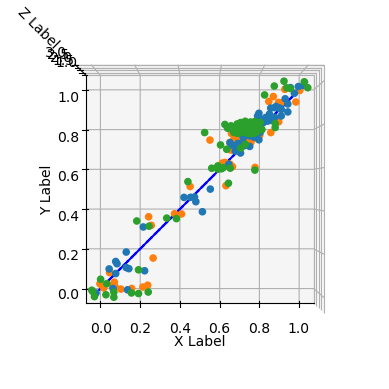

In [417]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680802)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# n = 100

# # For each set of style and range settings, plot n random points in the box
# # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for prop in ['dG','dH','dS']:
    xs = normalized_df_annotation[f'true_{prop}']
    zs = normalized_df_annotation[f'an_{prop}']
    ys = normalized_df_annotation[f'3_pred_{prop}']

    
    ax.scatter(xs, ys, zs, marker='o')
    # ax.plot_wireframe(X_line=[0,1], Y_line=[0,1], Z_line=[1,1], linestyle='--', color='r')
    start_point = [0, 0, zs[0]]  # Origin
    end_point = [1, 1, zs[0]]    # End point
    ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], [start_point[2], end_point[2]],linestyle='--', color='b')


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
# Set the viewing angle (elevation, azimuth)
# ax.view_init(elev=400, azim=45,)
# ax.view_init(elev=270, azim=180,)
# ax.view_init(elev=20, azim=20,)
ax.view_init(elev=90, azim=0,roll=90)
plt.show()

In [326]:
zs[0]

3

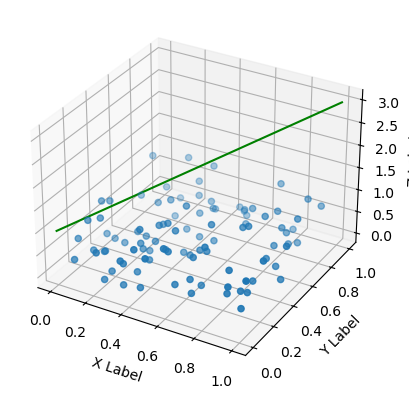

In [323]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import LinearRegression

# Sample data
xs = np.random.rand(100)
ys = np.random.rand(100)
zs = np.random.rand(100)

# Fit the data to a linear regression model
model = LinearRegression()
X = np.column_stack((xs, ys))
model.fit(X, zs)

# Generate points for the line of best fit
x_line = np.linspace(min(xs), max(xs), 1)
y_line = np.linspace(min(ys), max(ys), 2)
X_line, Y_line = np.meshgrid(x_line, y_line)
Z_line = model.predict(np.column_stack((X_line.flatten(), Y_line.flatten())))
Z_line = Z_line.reshape(X_line.shape)

# Plot the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)

# Plot the line of best fit as a dashed line
# ax.plot_wireframe(X_line, Y_line, Z_line, linestyle='--', color='r')
ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], [start_point[2], end_point[2]], color='g')


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [318]:
X_line

array([[0.01888418, 0.02878689, 0.0386896 , ..., 0.97944707, 0.98934978,
        0.99925249],
       [0.01888418, 0.02878689, 0.0386896 , ..., 0.97944707, 0.98934978,
        0.99925249],
       [0.01888418, 0.02878689, 0.0386896 , ..., 0.97944707, 0.98934978,
        0.99925249],
       ...,
       [0.01888418, 0.02878689, 0.0386896 , ..., 0.97944707, 0.98934978,
        0.99925249],
       [0.01888418, 0.02878689, 0.0386896 , ..., 0.97944707, 0.98934978,
        0.99925249],
       [0.01888418, 0.02878689, 0.0386896 , ..., 0.97944707, 0.98934978,
        0.99925249]])

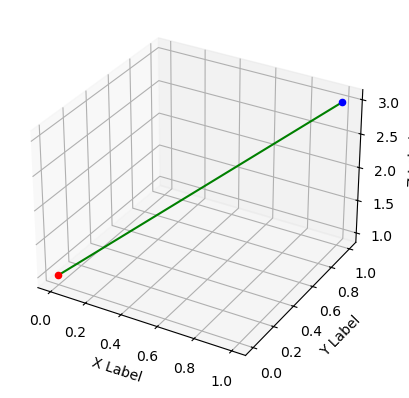

In [322]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the start and end points for the line segment
start_point = [0, 0, 1]  # Origin
end_point = [1, 1, 3]    # End point

# Plot the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the start and end points
ax.scatter(start_point[0], start_point[1], start_point[2], color='r', marker='o')
ax.scatter(end_point[0], end_point[1], end_point[2], color='b', marker='o')

# Plot the line segment connecting the start and end points
ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], [start_point[2], end_point[2]], color='g')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


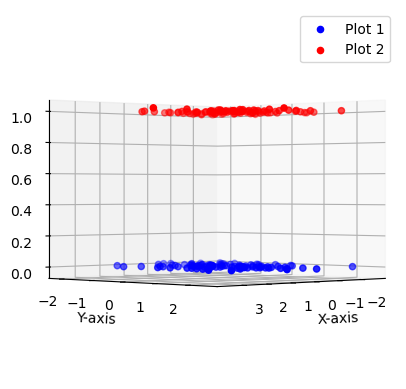

In [336]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some random data for two scatter plots
x1 = np.random.randn(100)
y1 = np.random.randn(100)
z1 = np.zeros_like(x1)

x2 = np.random.randn(100)
y2 = np.random.randn(100)
z2 = np.ones_like(x2)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the first scatter plot
ax.scatter(x1, y1, z1, color='blue', label='Plot 1')

# Plot the second scatter plot
ax.scatter(x2, y2, z2, color='red', label='Plot 2')

# Add labels and a legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.legend()

# Set the viewing angle (elevation, azimuth)
ax.view_init(elev=0, azim=45)

# Show the plot
plt.show()


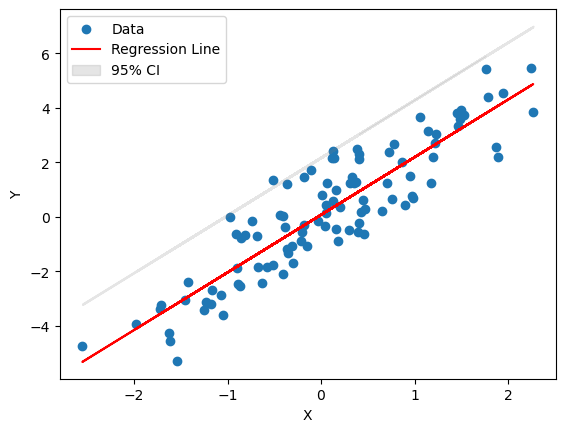

In [405]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, t

# Generate some sample data
np.random.seed(0)
x = np.random.randn(100)
y = 2 * x + np.random.randn(100)

# Fit the regression line using linregress
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the confidence interval for the slope
alpha = 0.05  # significance level
df = len(x) - 2  # degrees of freedom
t_critical = t.ppf(1 - alpha/2, df)  # t-value for 95% confidence interval
std_error_slope = std_err / np.sqrt(np.sum((x - np.mean(x))**2))
confidence_interval = t_critical * std_error_slope

# Plot the data points
plt.scatter(x, y, label='Data')

# Plot the regression line
plt.plot(x, intercept + slope * x, color='red', label='Regression Line')

# Plot the confidence interval
plt.fill_between(x, (intercept + (slope - confidence_interval)) + slope * x, 
                 (intercept + (slope + confidence_interval)) + slope * x, 
                 color='gray', alpha=0.2, label='95% CI')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Show the plot
plt.show()


## 2D CNN

In [ ]:

# for resample and for descriptor
p = "/users/qdb16186/dev/CV/1/Granulated/"
name="1DConv_mt_Granulatedresample_predictions_intermitent.csv"
desc_type = ['Granulated', 'OHEP', 'LP_dec2', 'DNA-Groups','RF-Score', 'CountDNAp', 'H-Bonding'] 
    # for prop in ['dH','dG','dS','Tm']:
for desc in desc_type:
    for resample in range(0,50):
        submission = pd.DataFrame()
        for prop in ['dH','dG','dS']:
                p = f"/users/qdb16186/CNN_stk/CV/{resample}/{desc}/1DConv_st_{prop}/"
                name = f"test.csv"
                df=pd.read_csv(f'{p}{name}')
                # Extracting columns with specific names
                specific_columns = ['y_pred','y_true']
                extracted_df = df[specific_columns]
                
                # Renaming columns
                extracted_df.columns = [prop,f'true_{prop}']
                submission = pd.concat([extracted_df,submission],axis=1)
        GHS_text(submission,desc,'ST')

In [423]:
resample=1
desc='OHEP'
prop='dG'
p = f"/users/qdb16186/CNN_stk/CV/{resample}/{desc}/1DConv_st_{prop}/"
name = f"test.csv"
df=pd.read_csv(f'{p}{name}')

In [434]:
from  Untitled.ipynb import test

ModuleNotFoundError: No module named 'Untitled'

In [456]:
# import test
# from test import test_print
%run test.py


In [457]:
test_print()


Hello


# SHAPLEY ANALYSIS

In [1]:
!pip install shap --force-reinstall

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 540 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 13.1 MB 125.7 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 14.0 MB/s  eta 0:00:01
     |████████████████████████████████| 13.4 MB 105.3 MB/s eta 0:00:01
     |████████████████████████████████| 18.2 MB 116.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 42.2 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 4.9 MB/s  eta 0:00:01
  Using cached scipy-1.13.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
     |████████████████████████████████| 43.9 MB 127.4 MB/s eta 0:00:01
     |████████████████████████████████| 505 kB 110.5 MB/s eta 0:00:01
     |████████████████████████████████| 229 kB 107.5 MB/s eta 0:00:01
     |████████████████████████████████| 345 kB 116.7 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 127.1 MB/s e

In [4]:
!pip install numpy==1.20.3 --force-reinstall

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.20.3-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.20.3 which is incompatible.
jax 0.4.20 requires numpy>=1.22, but you have numpy 1.20.3 which is incompatible.
tensorflow-gpu 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.12.0 which is incompatible.
tensorflow-gpu 2.8.0 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.12.3 which is incompatible.


In [2]:
!pip show numpy

Name: numpy
Version: 1.26.4
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2023, NumPy Developers.
        All rights reserved.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are
        met:
        
            * Redistributions of source code must retain the above copyright
               notice, this list of conditions and the following disclaimer.
        
            * Redistributions in binary form must reproduce the above
               copyright notice, this list of conditions and the following
               disclaimer in the documentation and/or other materials provided
               with the distribution.
        
            * Neither the name of the NumPy Developers nor the names of any
               contributors may be used to endorse or promo

In [3]:
import numpy as np
np.__version__

'1.26.4'

In [15]:
import shap

In [13]:

p = "/users/qdb16186/dev/CV/1/Granulated/"
name="1DConv_mt_Granulatedresample_predictions_intermitent.csv"
desc_type = ['Granulated', 'OHEP', 'LP_dec2', 'DNA-Groups']#'RF-Score', 'CountDNAp', 'H-Bonding'] 
# desc_type = ['H-Bonding'] 
    # for prop in ['dH','dG','dS','Tm']:
for desc in desc_type:
    for resample in range(0,50):
        submission = pd.DataFrame()
        for prop in ['dH','dG','dS']:
                p = f"/users/qdb16186/CNN_stk/CV/{resample}/{desc}/1DConv_st_{prop}/"
                name = f"test.csv"
                df=pd.read_csv(f'{p}{name}')
                # Extracting columns with specific names
                specific_columns = ['y_pred','y_true']
                extracted_df = df[specific_columns]
                
                # Renaming columns
                extracted_df.columns = [prop,f'true_{prop}']
                submission = pd.concat([extracted_df,submission],axis=1)

In [12]:

# for resample and for descriptor
p = "/users/qdb16186/dev/CV/1/Granulated/"
name="1DConv_mt_Granulatedresample_predictions_intermitent.csv"
desc_type = ['Granulated', 'OHEP', 'LP_dec2', 'DNA-Groups','RF-Score', 'CountDNAp', 'H-Bonding'] 
    # for prop in ['dH','dG','dS','Tm']:
for desc in desc_type:
    for resample in range(0,50):
        p = f"/users/qdb16186/dev/CV/{resample}/{desc}/"
        # p = f"/users/qdb16186/CNN_stk/CV/{resample}/{desc}/"
        name = f"1DConv_mt_{desc}resample_predictions_intermitent.csv"
        df=pd.read_csv(f'{p}{name}')
        # Extracting columns with specific names
        specific_columns = ['3_pred_dH', '3_pred_dG', '3_pred_dS','true_dH' ,'true_dS' ,'true_dG']
        extracted_df = df[specific_columns]
        
        # Renaming columns
        extracted_df.columns = ['dH', 'dG', 'dS', 'true_dH' ,'true_dS' ,'true_dG']
        # GHS_text(extracted_df,desc,'MT')

In [13]:
import tensorflow as tf
from tensorflow.keras.models import load_model


## Model Architecture to laod

In [14]:
def build_model(hp=0):
     
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x_layer=inputs
    
    # Conv layer 1
    x_layer = keras.layers.Conv1D(32, 
            kernel_size=(3), 
            strides=(2), 
            padding='valid', 
            activation='relu', 
            input_shape=(250,1),
            name = 'conv1d_1'
            )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = 'batchnorm_1')(x_layer)



    # Conv layer 2
    x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        name = f'conv1d_2'
                        )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = f'batchnorm_2')(x_layer)


#     FLATTEN AFTER CONVOLUTIONS
    x_layer = keras.layers.Flatten(name = 'flatten')(x_layer)
    
    
    #Node 1
    node1_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node1_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node1_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node1_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node1_layer)
    
    #Node 2
    node2_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node2_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node2_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node2_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node2_layer)
    
    #Node 3
    node3_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node3_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node3_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node3_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node3_layer)
    
    #Node 4
    node4_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node4_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node4_layer = keras.layers.Dense(
                32,
                activation='relu',
                use_bias=True,
                name='node4_2',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node4_layer)



#     OUTPUT LAYERS

    # output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x_layer)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x_layer)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x_layer)
    # output_4 = keras.layers.Dense(1, name='melting_temperature')(x_layer)

    output_1 = keras.layers.Dense(1, name='dH')(node1_layer)
    output_2 = keras.layers.Dense(1, name='dS')(node2_layer)
    output_3 = keras.layers.Dense(1, name='dG')(node3_layer)
    output_4 = keras.layers.Dense(1, name='Tm')(node4_layer)
    

    model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4])
    return model

## Shapley

In [16]:
model2 = build_model()
model2.load_weights(f'{p}1DConv_mt_{desc}/model_checkpoint/cp.h5')

2024-06-13 20:30:46.934677: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 1)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 124, 32)      128         ['input_1[0][0]']                
                                                                                                  
 maxpooling_1 (MaxPooling1D)    (None, 62, 32)       0           ['conv1d_1[0][0]']               
                                                                                                  
 batchnorm_1 (BatchNormalizatio  (None, 62, 32)      128         ['maxpooling_1[0][0]']           
 n)                                                                                           

In [18]:
df=pd.read_csv(f"/users/qdb16186/dev/CV/{resample}/train.csv")
df

,Unnamed: 0,ID
0,14,15
1,186,187
2,174,175
3,56,57
4,183,184
...,...,...
144,203,204
145,137,138
146,72,73
147,140,141


In [19]:
df=pd.read_csv("Lomzov_dataset_IY.csv")


In [43]:
df=pd.read_csv("Lomzov_dataset_IY.csv")
home=os.getcwd()
# data Generation
# cv_hp(df,home)

# # Actual instrucitons
# resample={resample}
# fold={fold}
# GSHT_list=['dH','dS','dG','Tm']
# desc='{desc}'
# # desc='HGST'
# prop = '{prop}' 
# prop = ['dH','dS','dG','Tm']
# model_name = f"1DConv_mt_{desc}" 
# epochs = 600
# batch  = 16

# """)

train, val, test = access_resample_csv(df,home,resample)
# train_fold, val_fold, test_fold = access_fold_csv(df,home,resample,fold)

y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test,desc)

In [46]:
desc
# test

'H-Bonding'

In [39]:
# Example selection (choosing output1) for multi-output model
output_selected = model2.get_layer('dH').output

# Create a new model with the same input but a single output
model_single_output = Model(inputs=model2.inputs, outputs=output_selected)


In [29]:
import shap


In [40]:
# Initialize the SHAP DeepExplainer for specific outputs (adjust output_indexes as needed)

explainer = shap.DeepExplainer(model_single_output, X_padded_train)


/users/qdb16186/.local/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [ ]:
explainer(X_padded_train)

In [ ]:
e = shap.DeepExplainer((model2.layers[0].input, model2.layers[-1].output), X_padded_train)
shap_values = e.shap_values(X_padded_test[1:5])

In [ ]:
# Visualize SHAP values for each task
shap.summary_plot(shap_values[0], sample_data, plot_type="bar", title="Task 1")
shap.summary_plot(shap_values[1], sample_data, plot_type="bar", title="Task 2")


In [42]:
tf.__version__

'2.12.0'

In [51]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 31.3 MB/s eta 0:00:00m eta 0:00:010:01:01


In [52]:
import xgboost


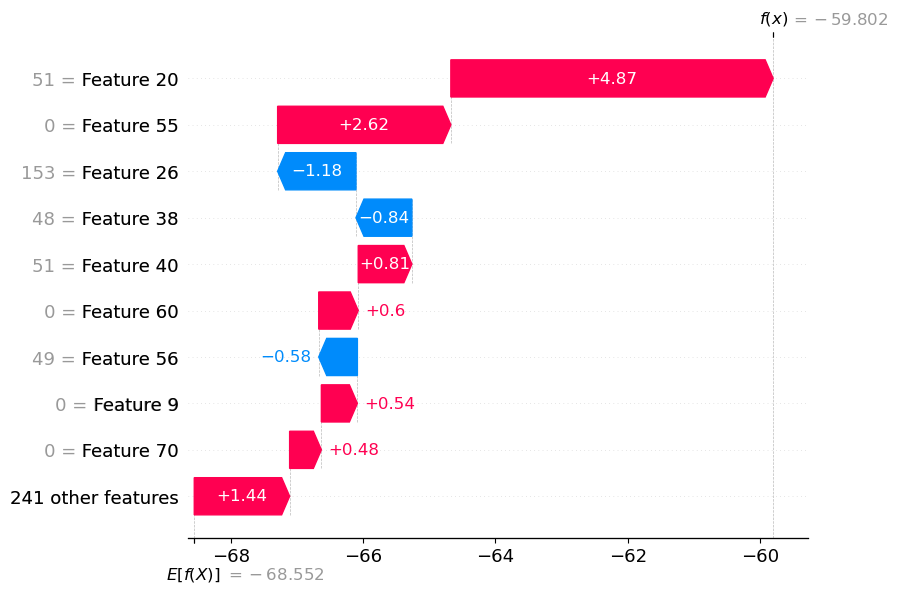

In [53]:


model = xgboost.XGBRegressor().fit(X_padded_train, y_1_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_padded_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [111]:
X_padded_train.shape

(149, 250)

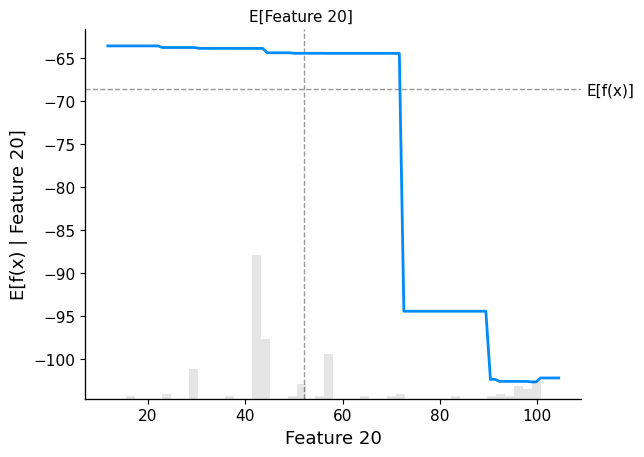

In [57]:
shap.partial_dependence_plot(
    "Feature 20",
    model.predict,
    X_padded_train,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

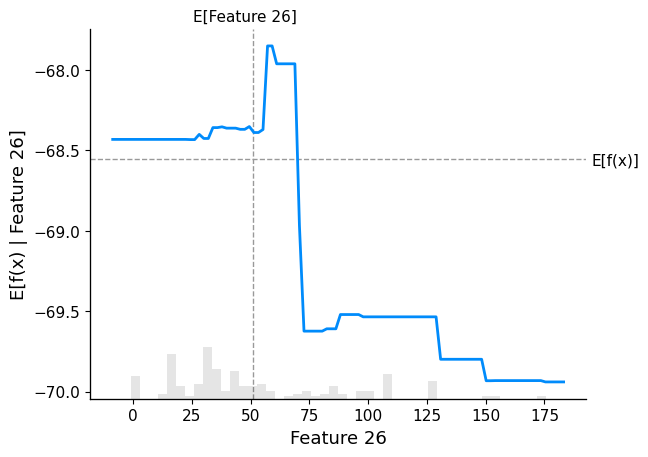

In [58]:
shap.partial_dependence_plot(
    "Feature 26",
    model.predict,
    X_padded_train,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

In [59]:
shap.plots.force(shap_values[0])

In [75]:
# shap_values

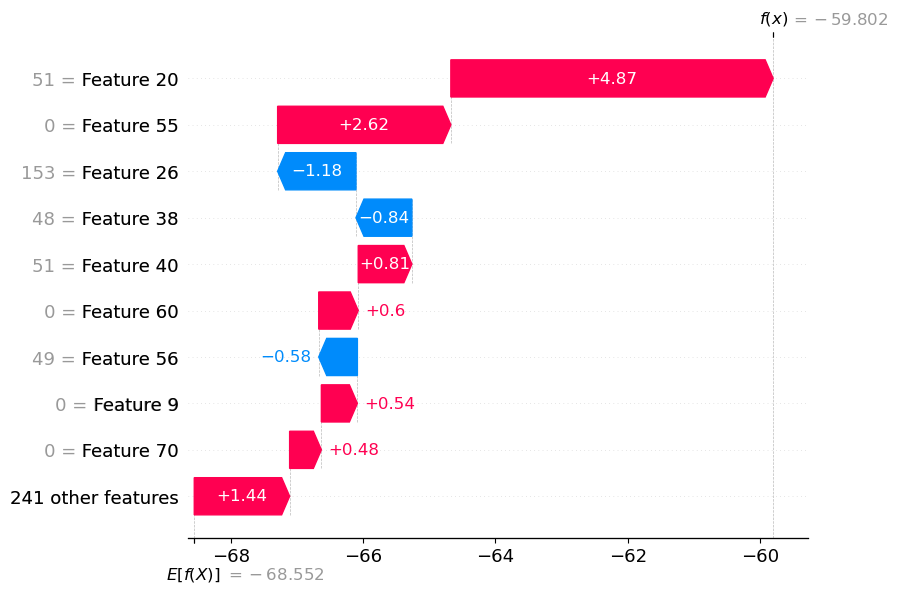

In [96]:
# shap.plots.heatmap(shap_values[0])
shap.plots.waterfall(shap_values[0])

In [95]:
print(shap_values.feature_names)

None


In [98]:
print(type(shap_values))
print(shap_values)

<class 'shap._explanation.Explanation'>
.values =
array([[ 0.15505832,  0.10466216,  0.03746423, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10019758,  0.07967813,  0.00413043, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.15527016, -0.04051705, -0.00430269, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.76653206,  0.01956746,  0.16667362, ...,  0.        ,
         0.        ,  0.        ],
       [-0.87781185,  0.03971428, -0.00637407, ...,  0.        ,
         0.        ,  0.        ],
       [-0.54575527,  0.05301312,  0.00126757, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

.base_values =
array([-68.552345, -68.552345, -68.552345, -68.552345, -68.552345,
       -68.552345, -68.552345, -68.552345, -68.552345, -68.552345,
       -68.552345, -68.552345, -68.552345, -68.552345, -68.552345,
       -68.552345, -68.552345, -68.552345, -68.552345, -68.552345,
       -68.552345, -68.552345, -68.552

In [100]:
if isinstance(shap_values, np.ndarray):
    print(shap_values.shape)
elif isinstance(shap_values, pd.DataFrame):
    print(shap_values.columns)

In [ ]:
# Identify the correct index for "Feature 20"
feature_index = 19  # Assuming "Feature 20" is the 20th feature (0-based index)

# Plot the SHAP values scatter plot for "Feature 20"
shap.plots.scatter(shap_values[:, feature_index])

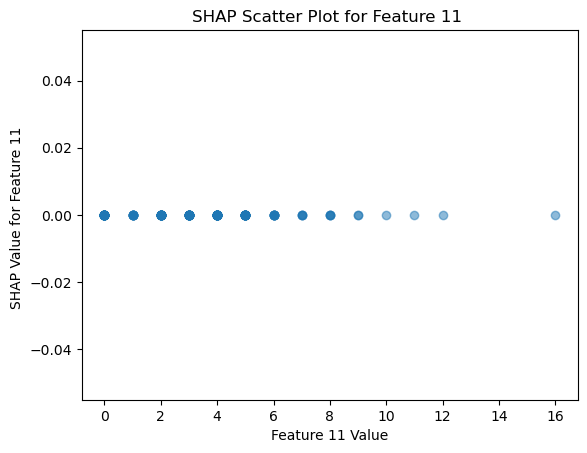

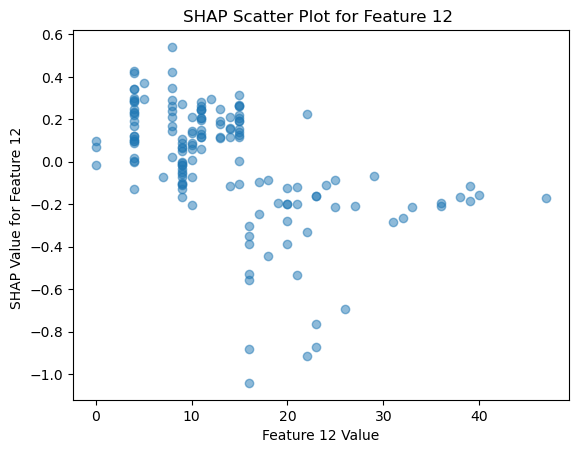

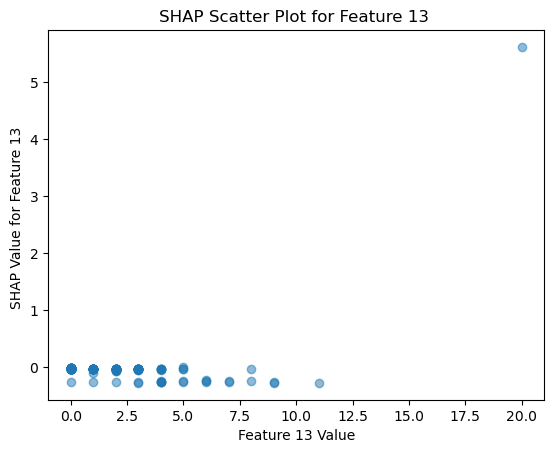

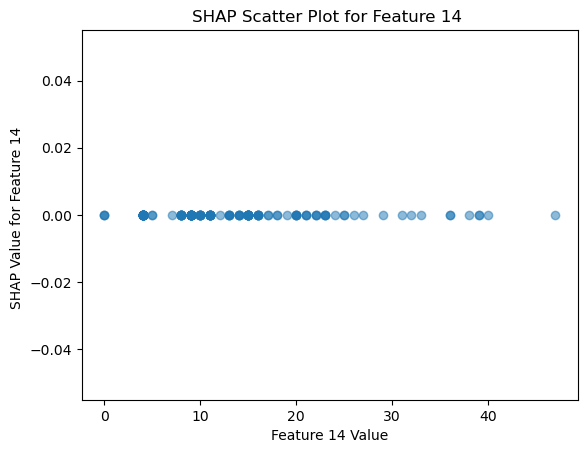

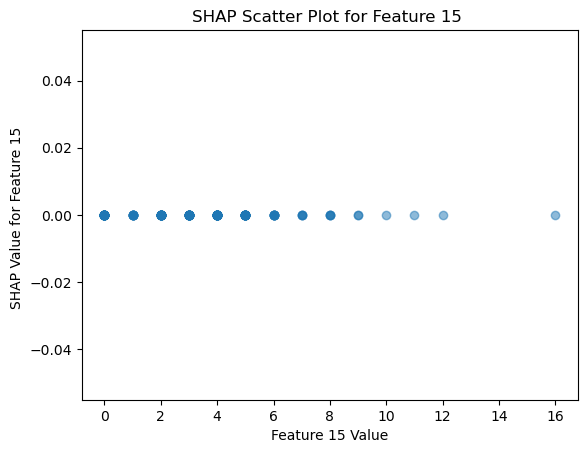

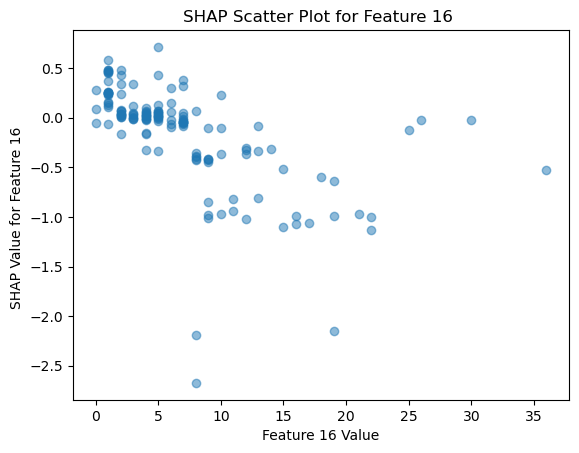

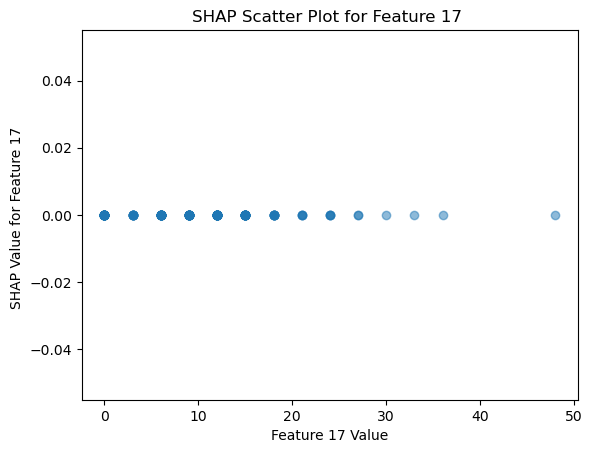

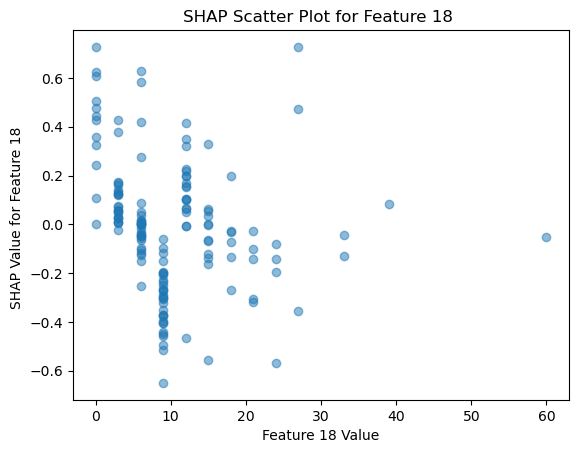

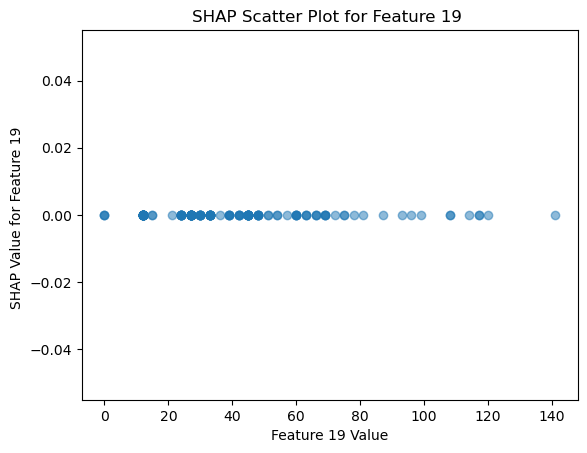

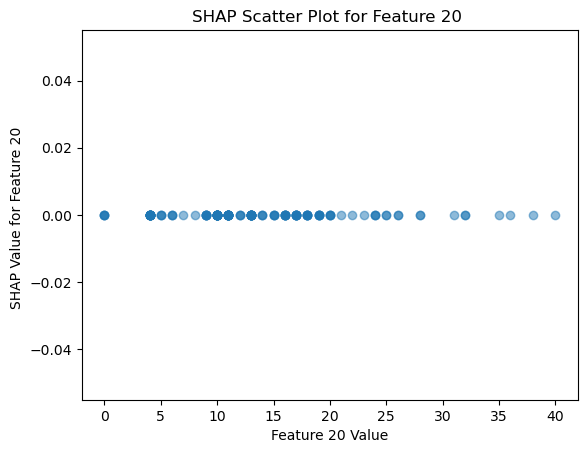

In [109]:
import matplotlib.pyplot as plt

# Extract SHAP values and feature data
shap_values_array = shap_values.values
data_array = shap_values.data
n=10
# Identify the correct index for "Feature 20"
for i in range(n,n+10):
    feature_index = i  # Assuming "Feature 20" is the 20th feature (0-based index)
    
    # Scatter plot for the SHAP values of "Feature 20"
    plt.scatter(data_array[:, feature_index], shap_values_array[:, feature_index], alpha=0.5)
    plt.xlabel(f'Feature {i+1} Value')
    plt.ylabel(f'SHAP Value for Feature {i+1} ')
    plt.title(f'SHAP Scatter Plot for Feature {i+1} ')
    plt.show()

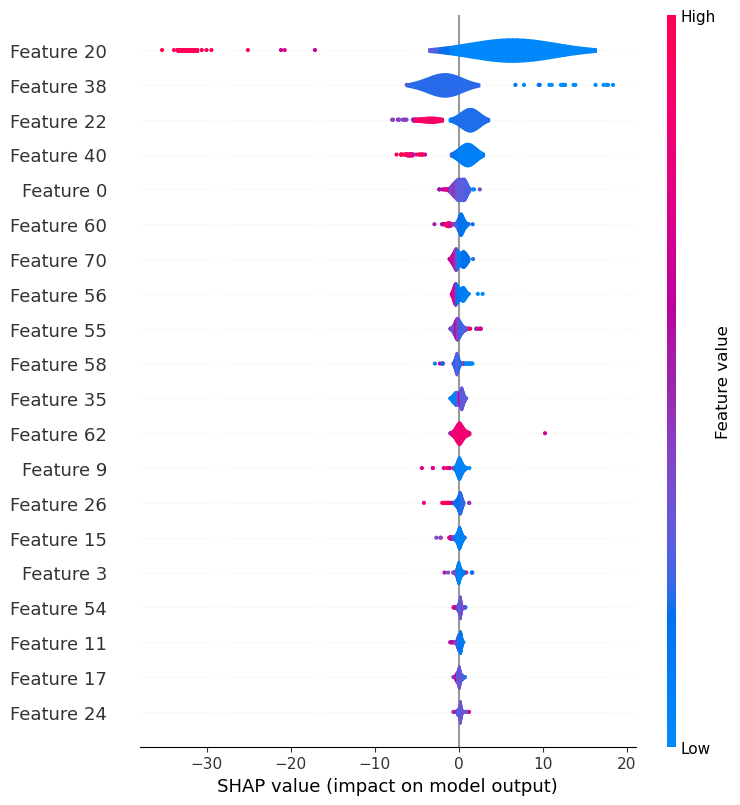

In [83]:
shap.plots.violin(shap_values)

In [69]:
shap.plots.scatter(shap_values, color=shap_values)

TypeError: object of type 'NoneType' has no len()

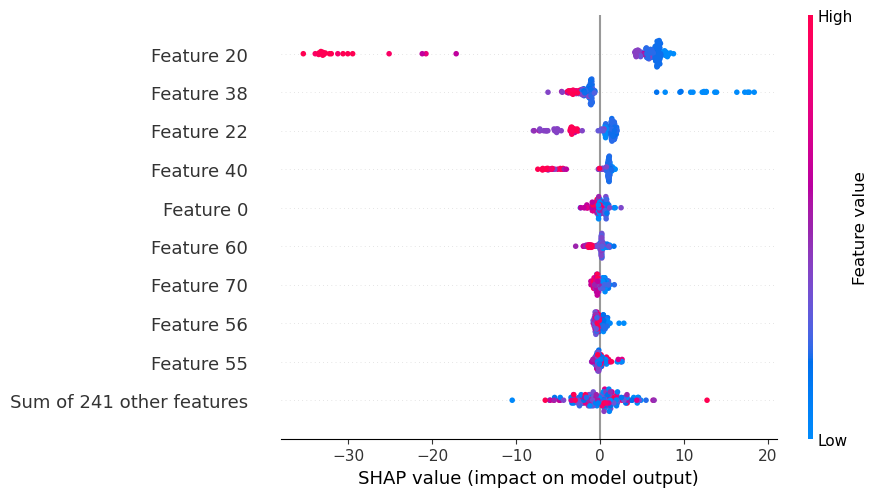

In [70]:
shap.plots.beeswarm(shap_values)